# CNN features visualization

We are aiming at training a convolutional neural network (CNN) to recognize mode of action (MoA) of chemical compound from cell microscopy images taken after treatment with these compounds. We will use transfer learning, importing a pre-trained CNN: Inception v3, and identifying the layers we want to retrain on our dataset. To achieve this, we want to visualize examples of the features that are detected by each layer. We will then keep the high level ones (edges), as they will be applicable to our cell images dataset. However, the layers identifiying too specific ones (like the eye of a cat, or the shape of a house) will be retrained in order to adapt them to our dataset.

In [56]:
# Let's firts import the packages we will require
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np



In [41]:
# Load the pre-trained Inception V3 model
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.eval();

Let's now load and pre-process an input image, and then define a function to visualize the feature of a layer of the CNN. 
. Inception v3 is originally designed to recognize a variety of objects, among which everyday objects like animals or vehicles, but also medical images. Let's start with an image of a cat. 


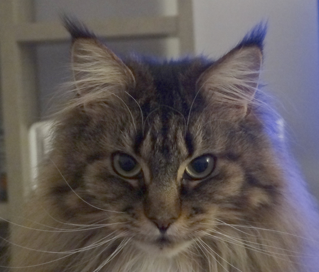

In [77]:
path = 'images/2016-02-01_08-14-24.jpg'
# Load the image
image = Image.open(path)

# Display the image
display(image.resize(( int(image.width * .1), int(image.height * .1))))


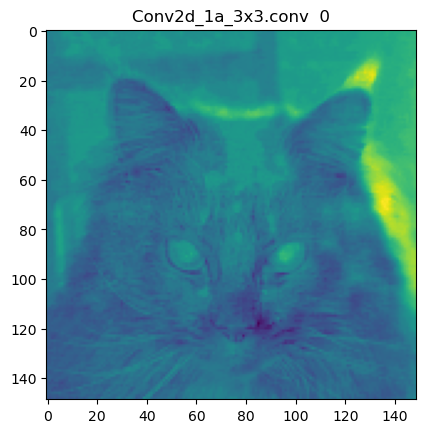

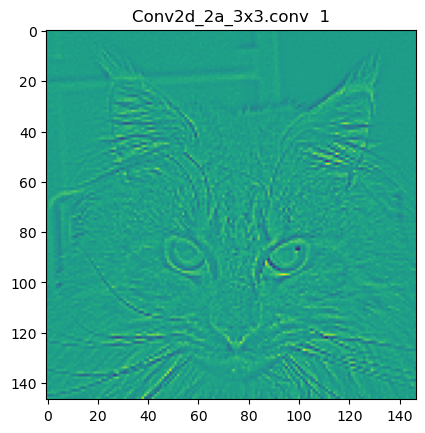

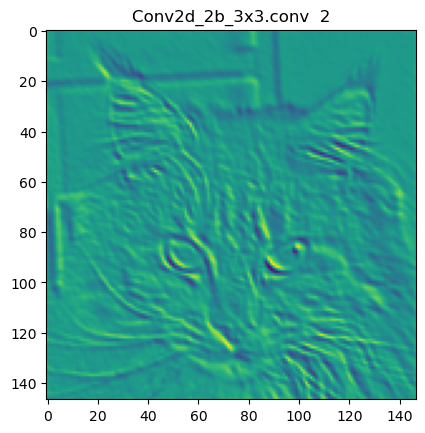

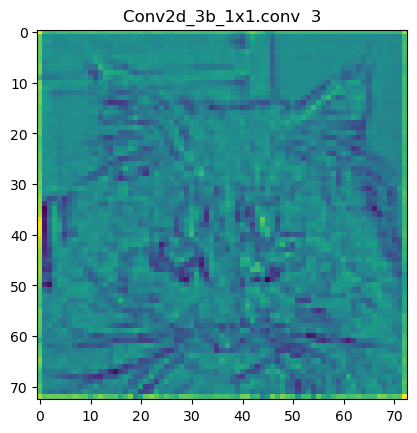

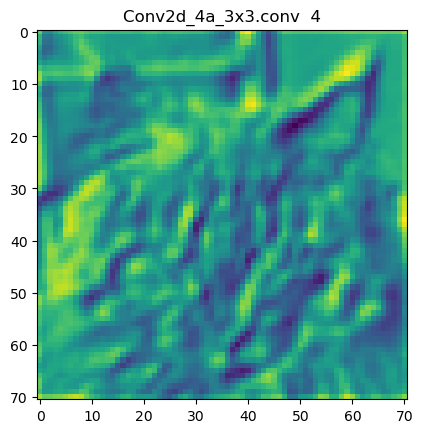

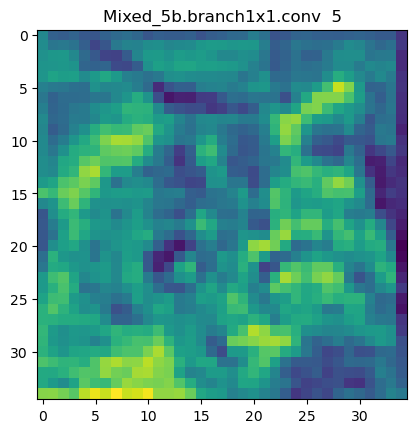

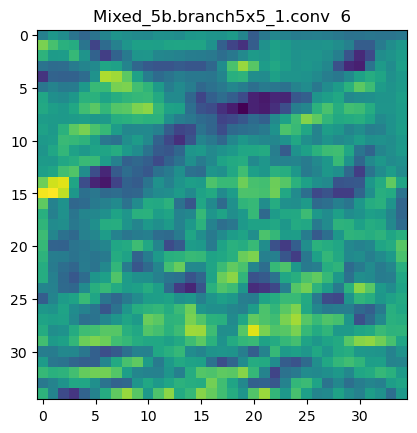

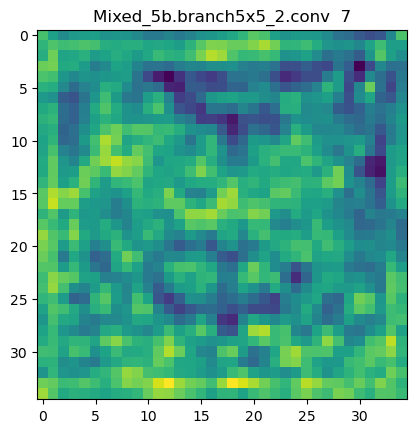

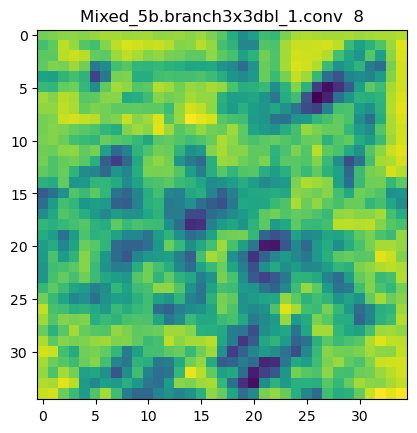

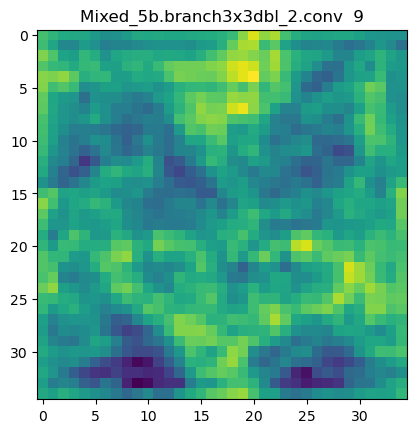

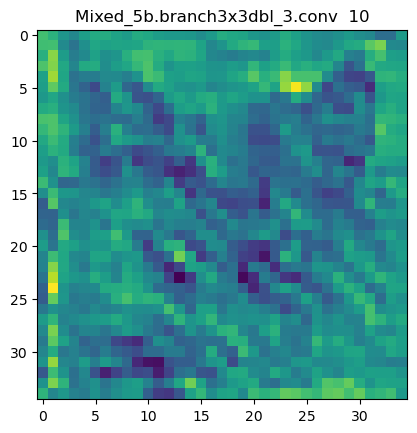

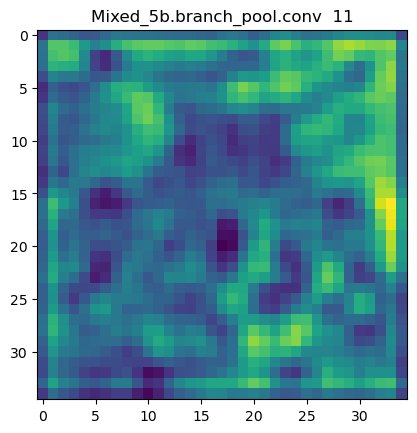

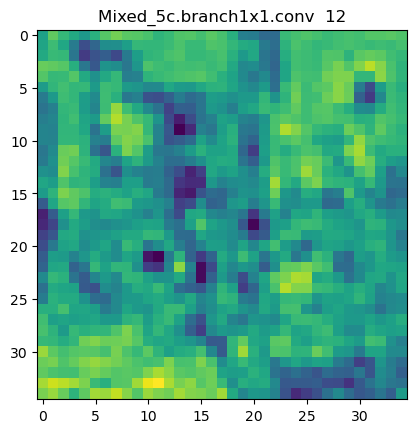

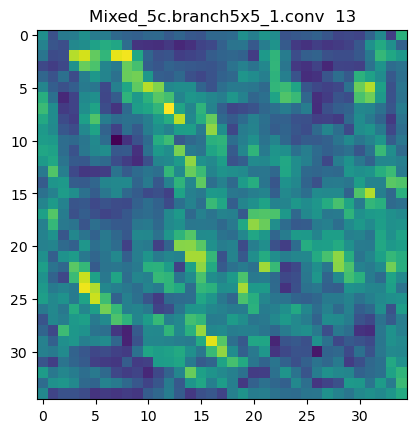

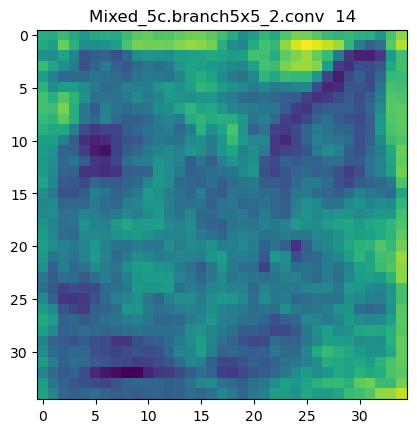

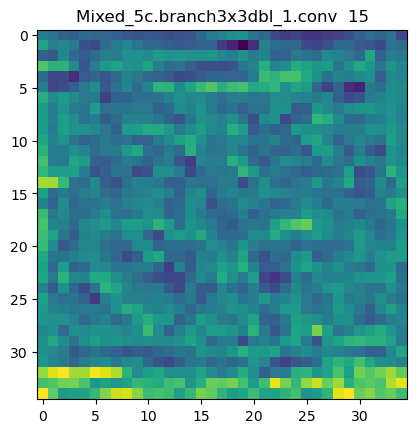

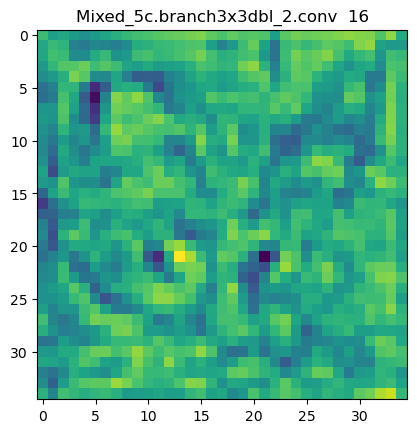

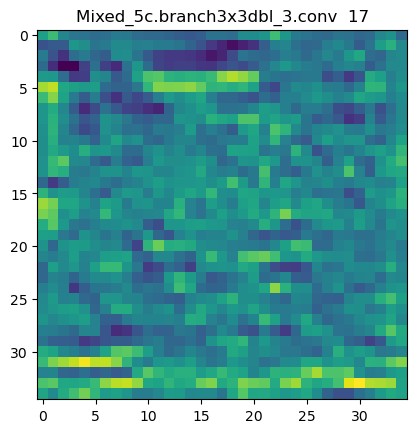

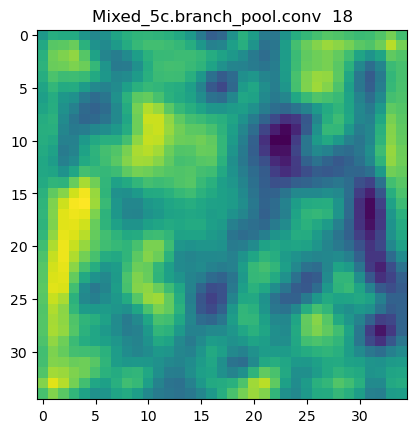

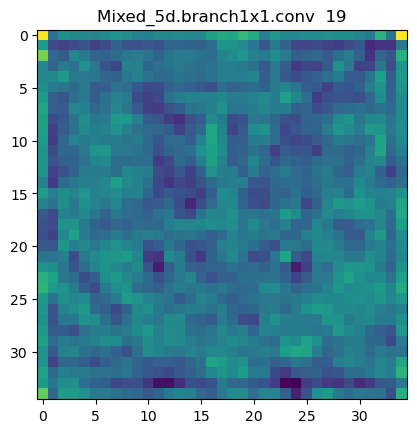

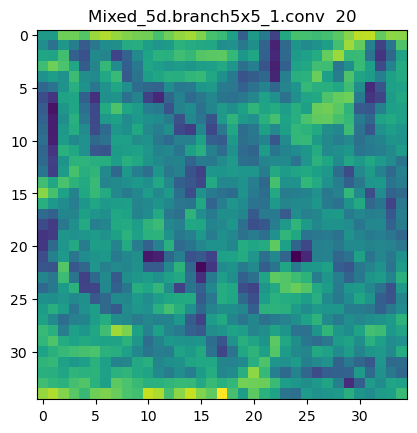

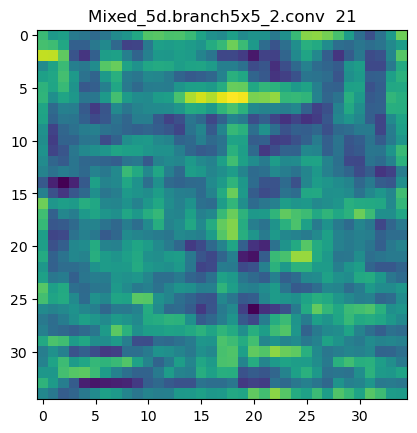

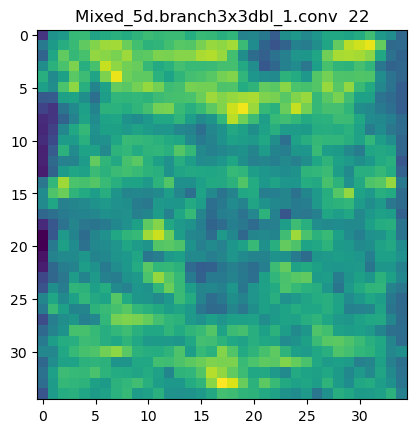

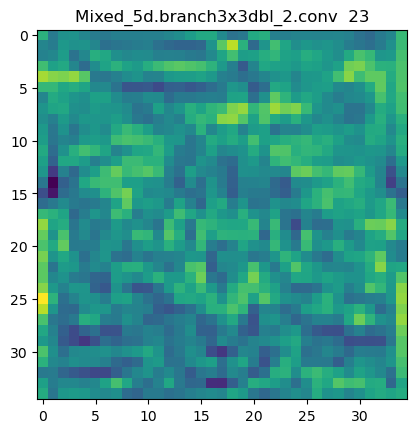

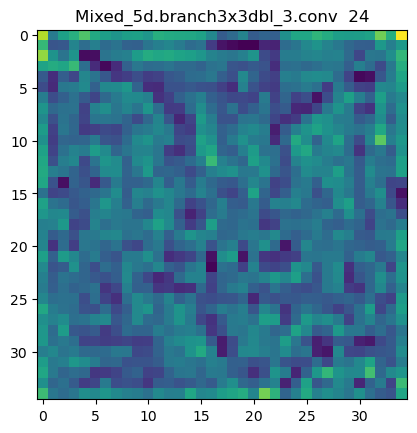

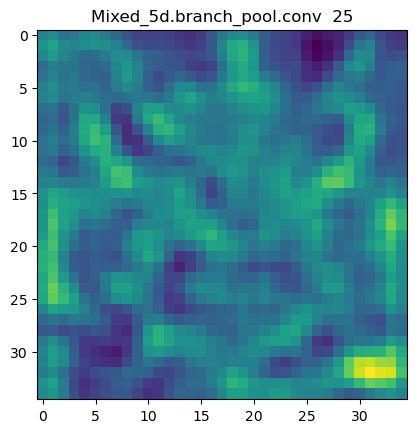

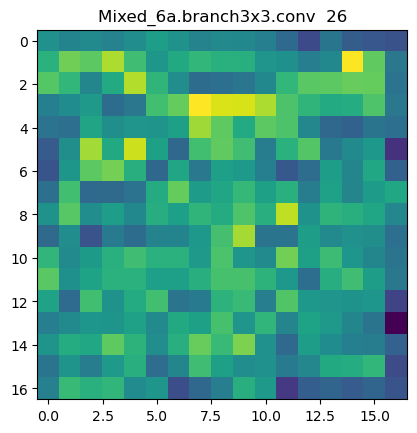

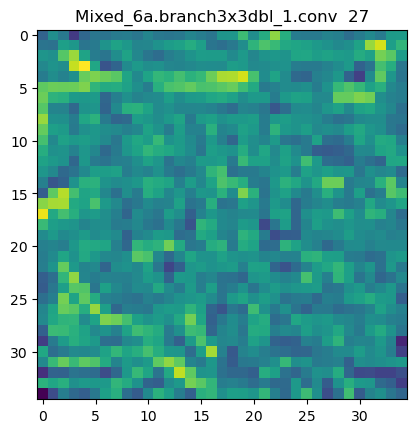

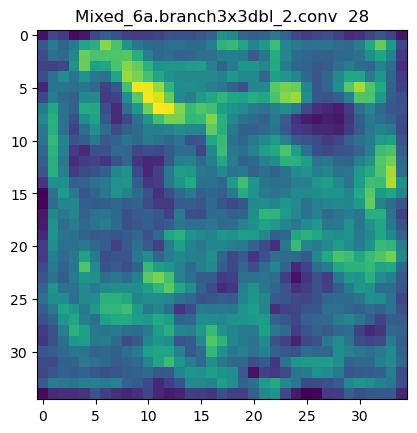

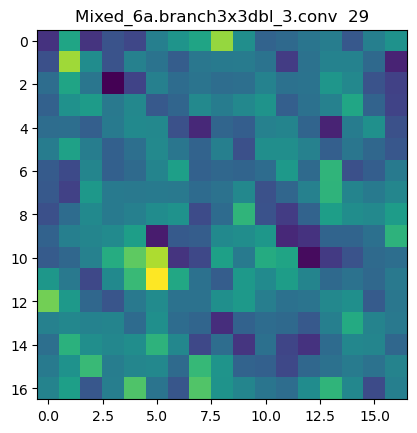

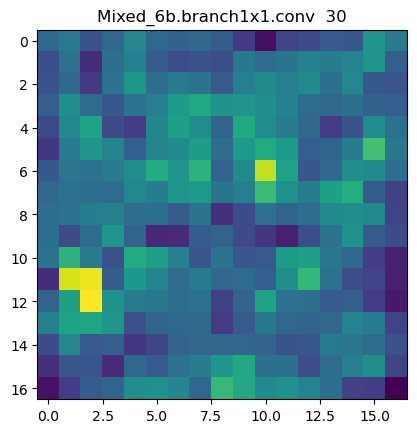

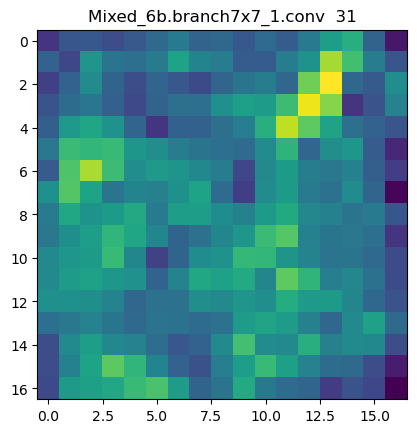

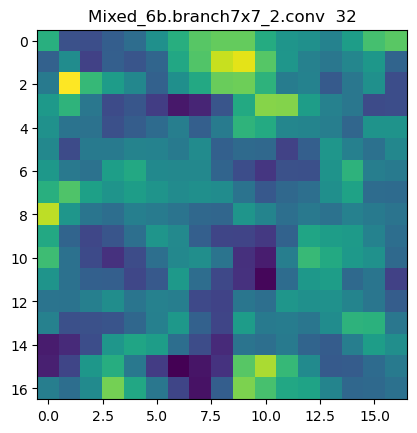

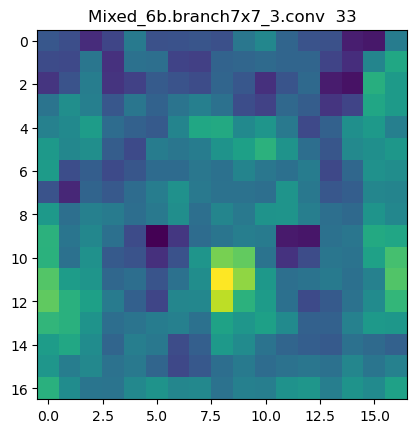

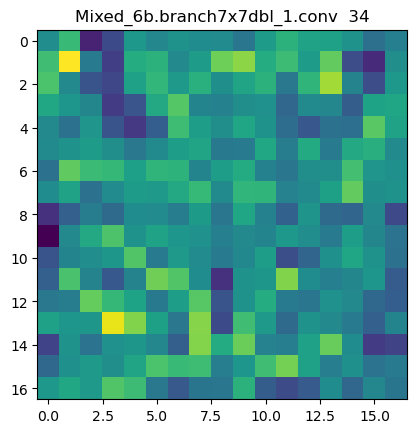

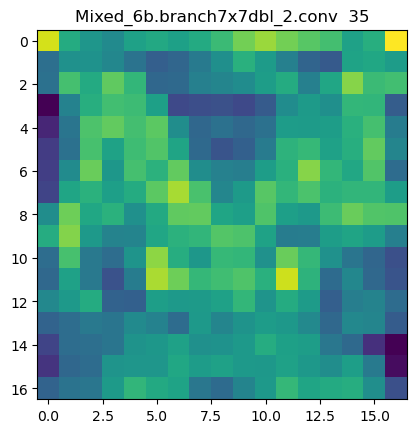

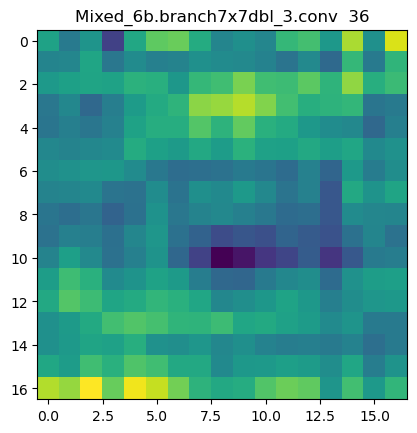

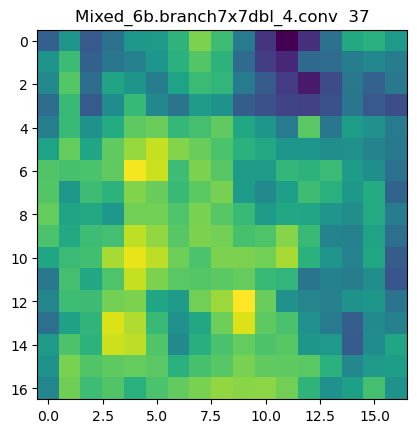

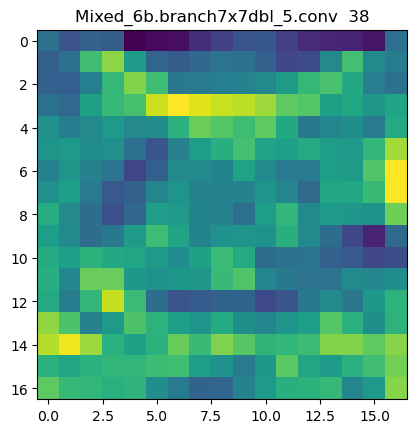

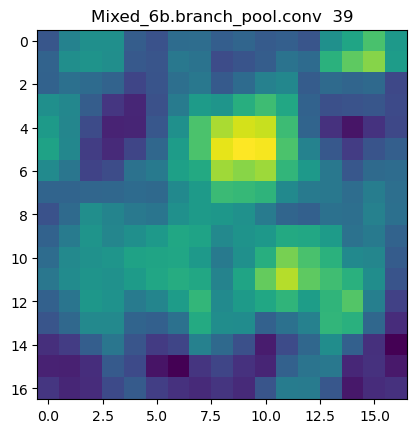

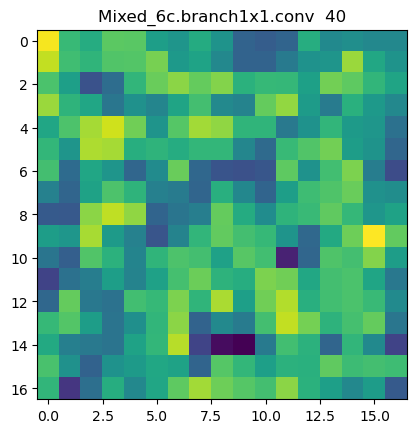

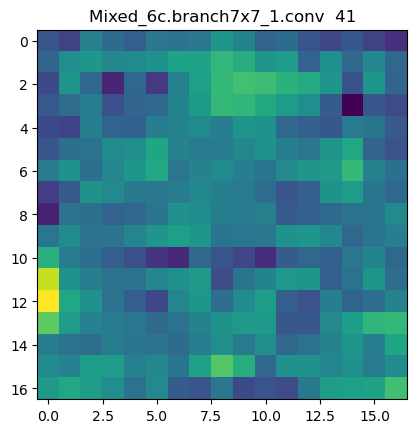

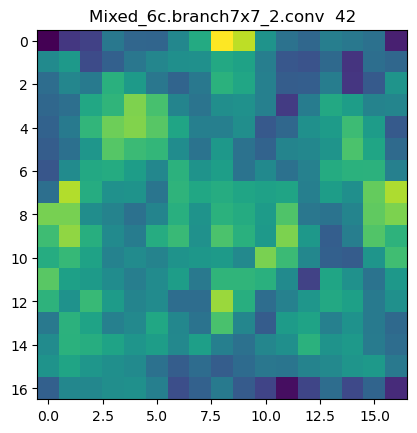

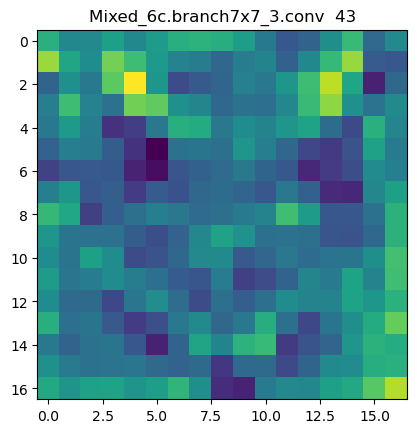

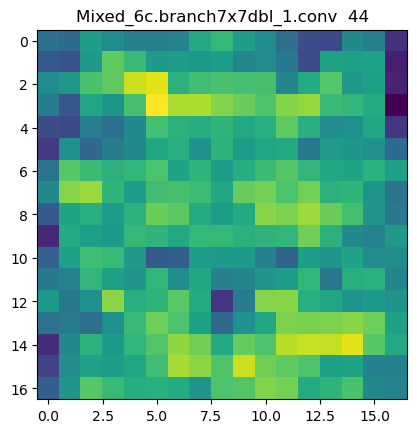

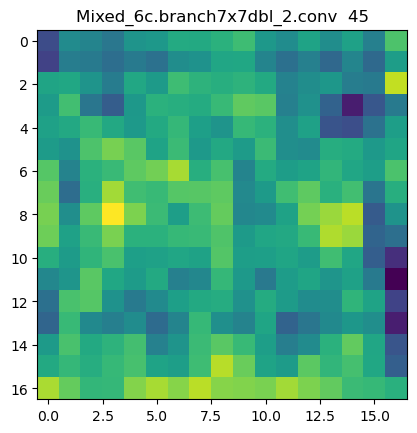

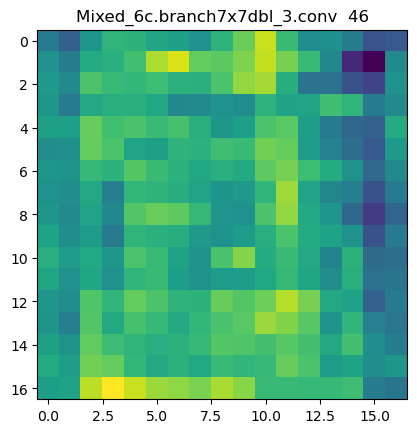

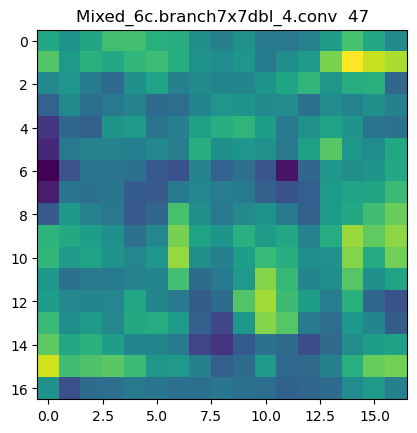

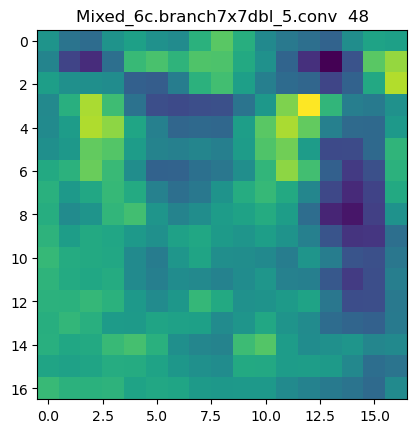

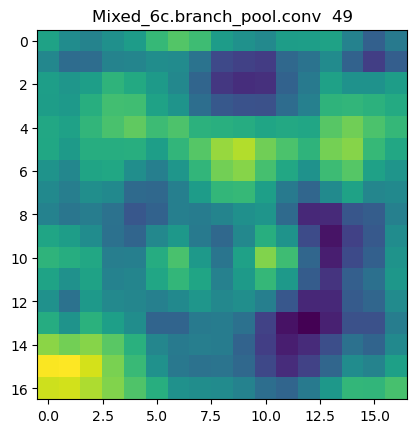

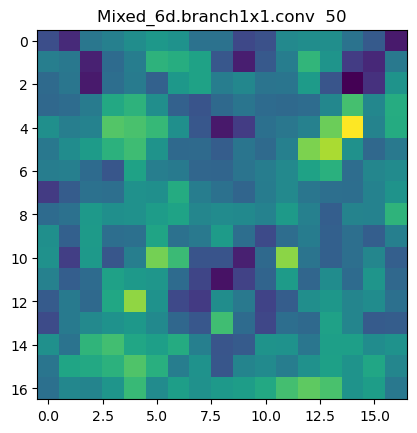

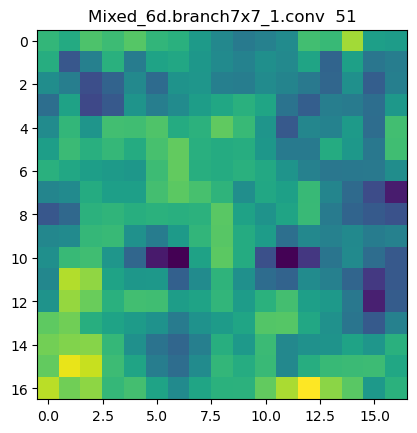

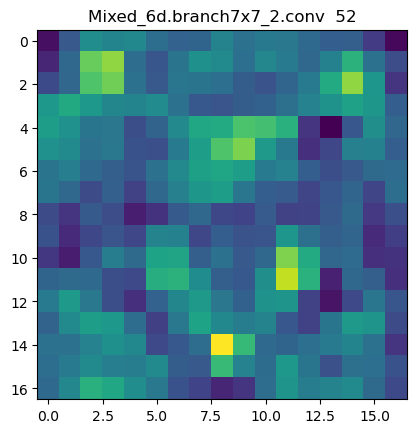

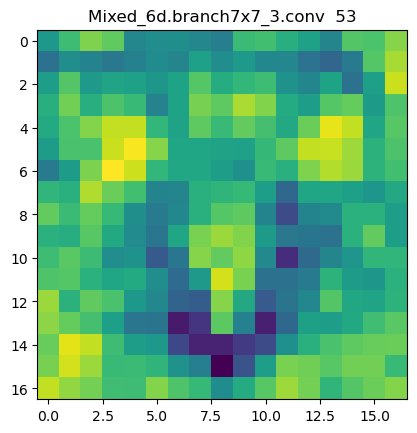

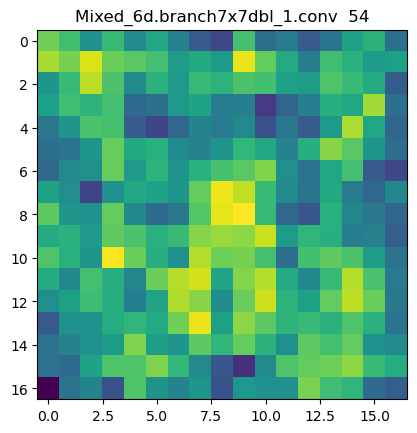

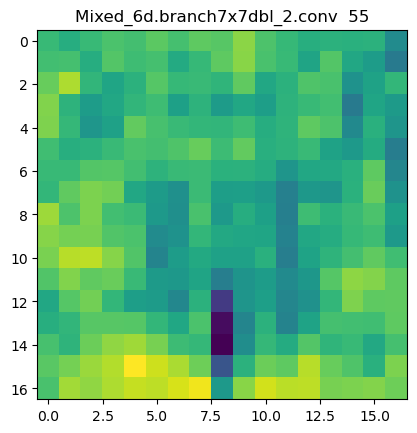

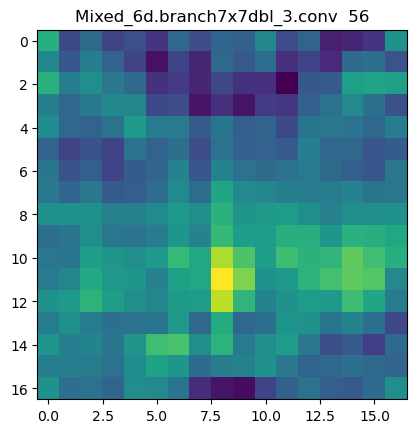

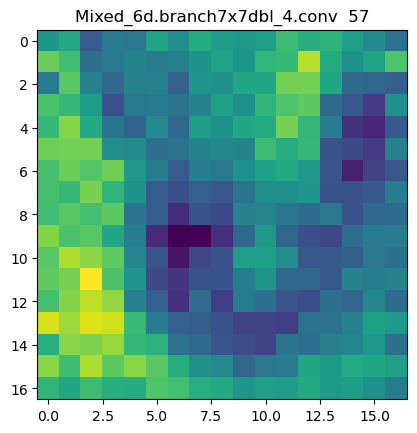

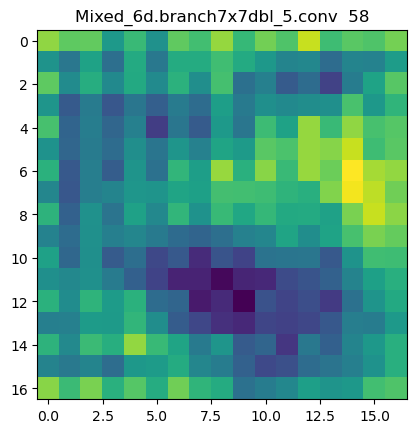

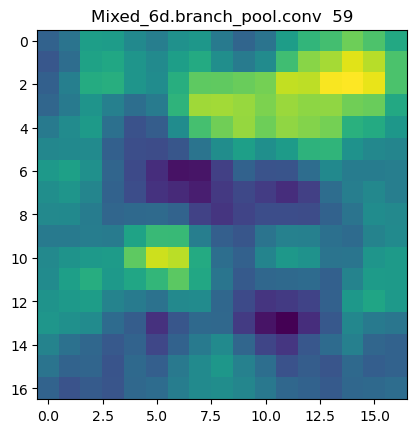

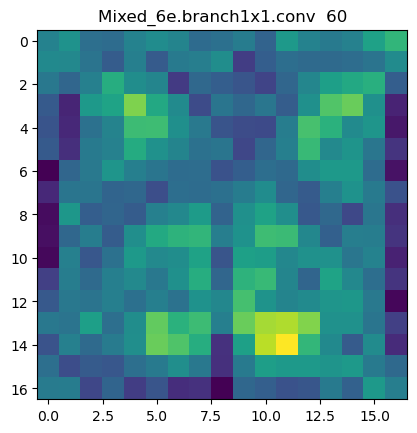

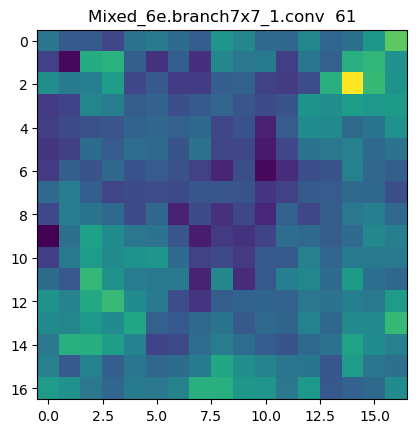

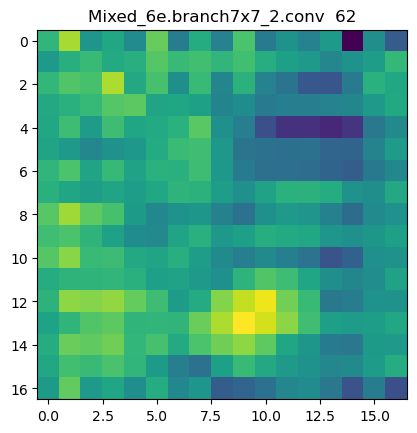

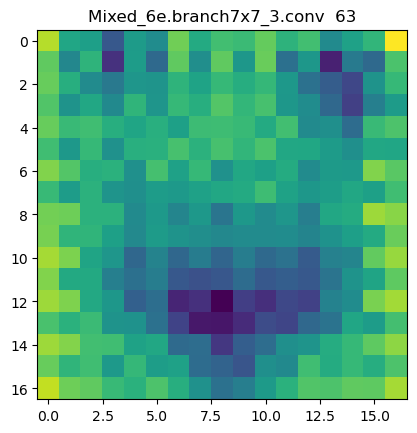

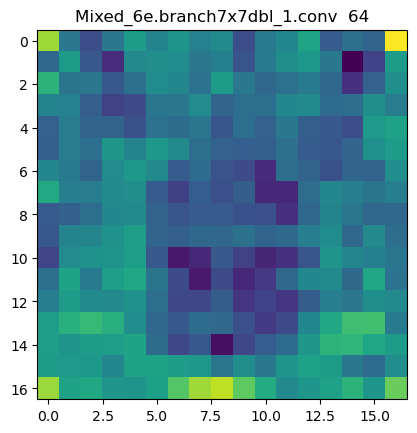

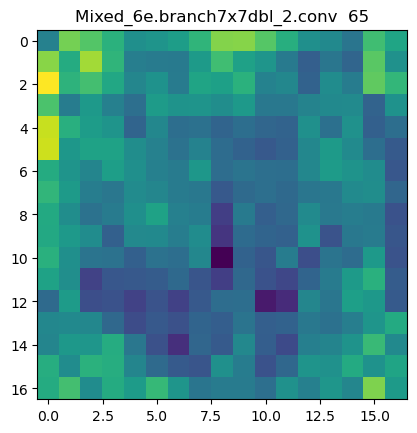

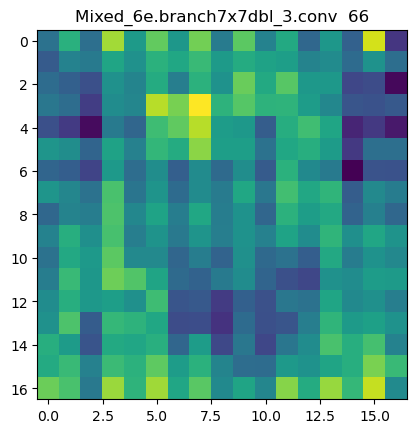

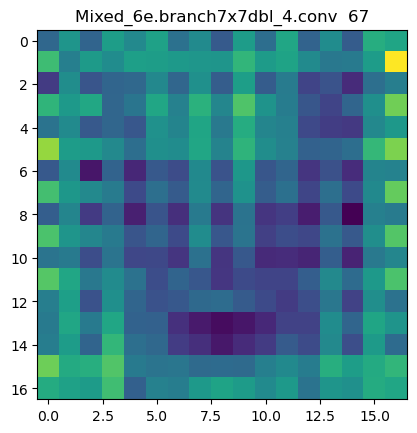

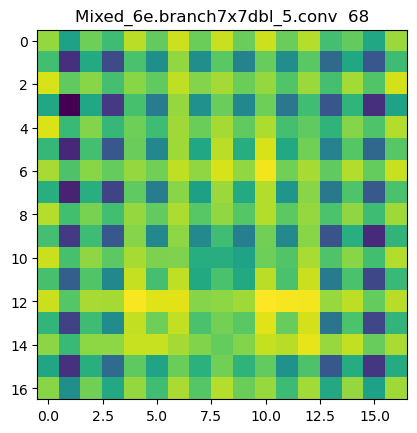

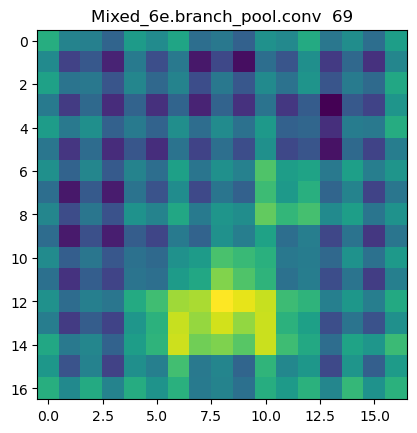

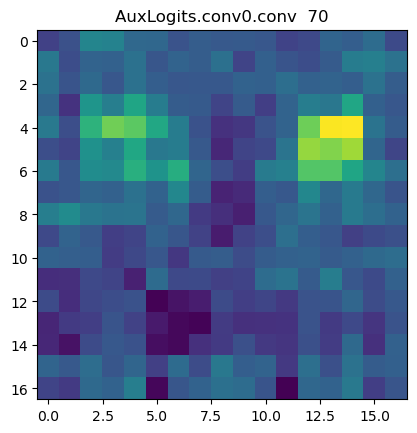

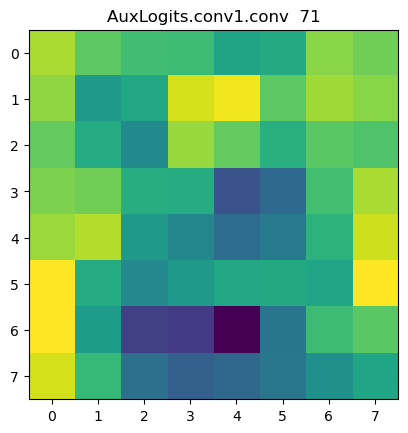

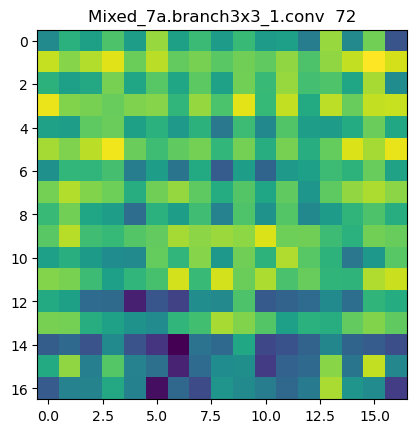

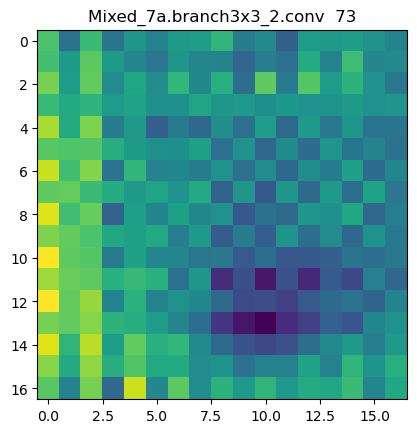

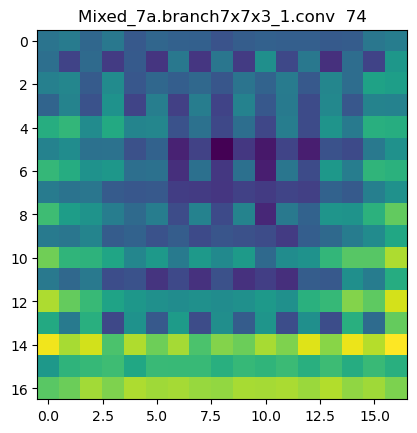

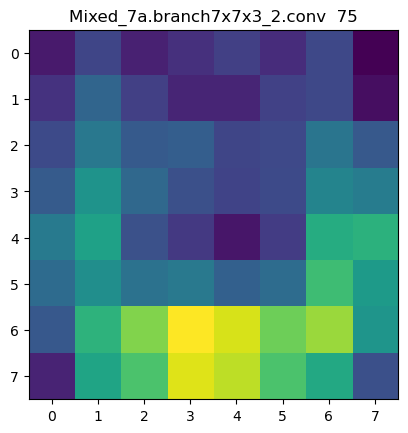

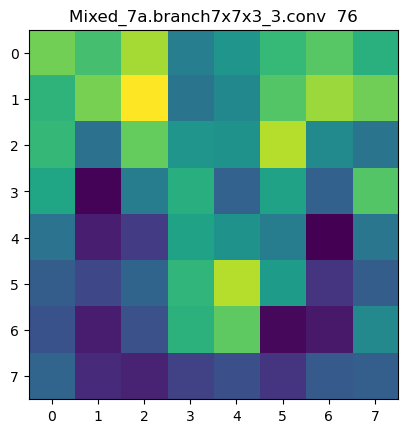

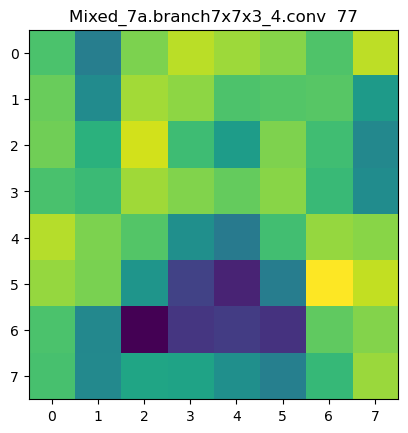

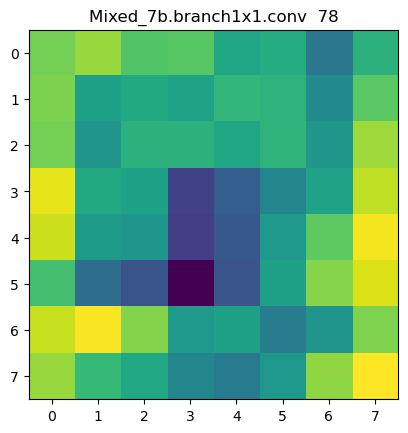

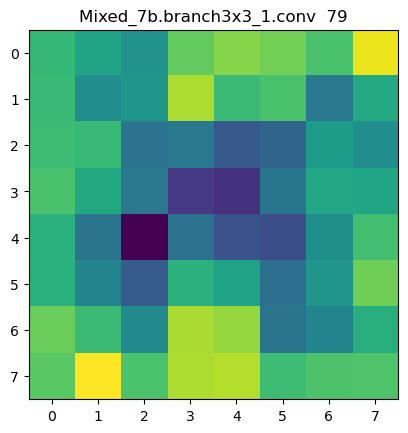

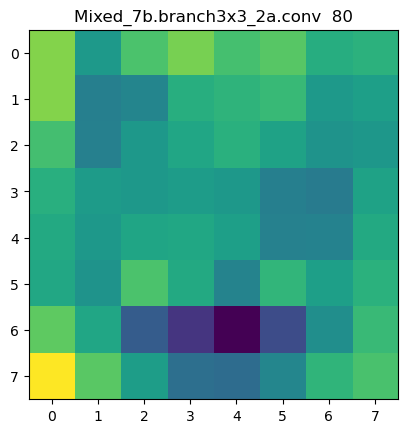

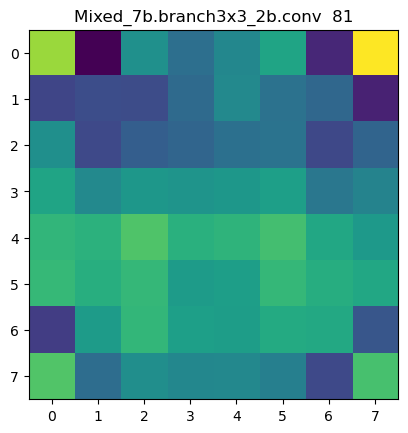

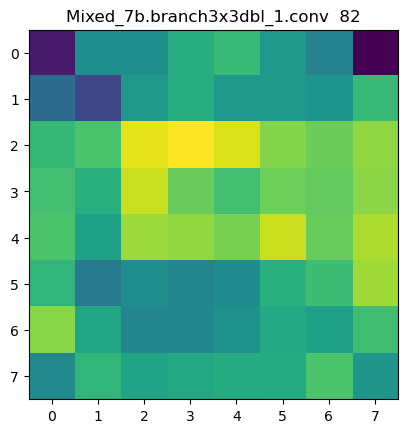

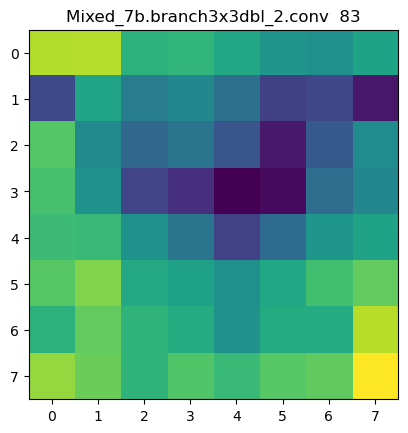

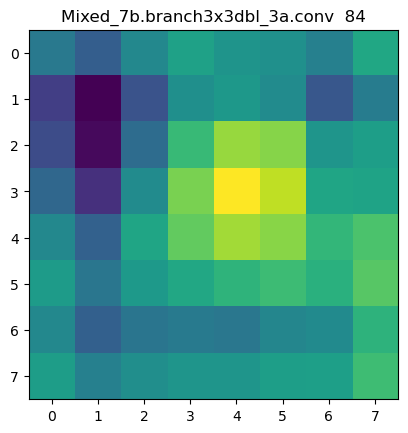

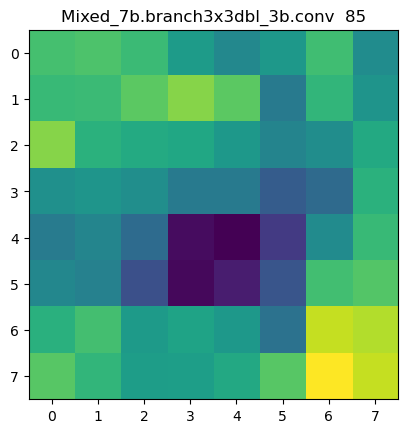

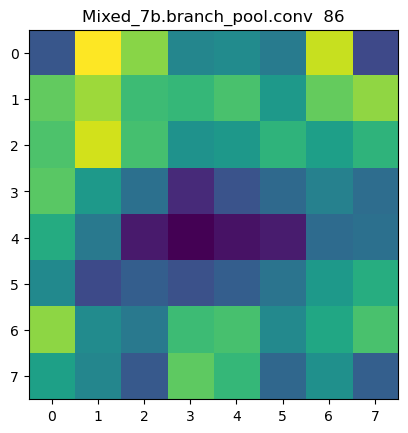

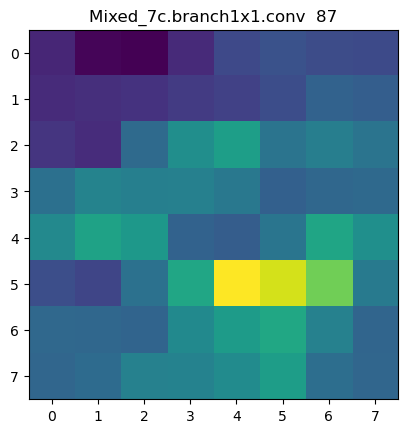

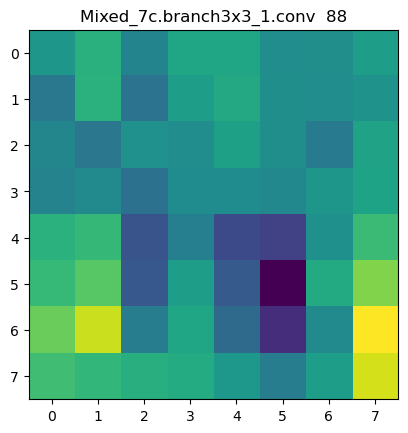

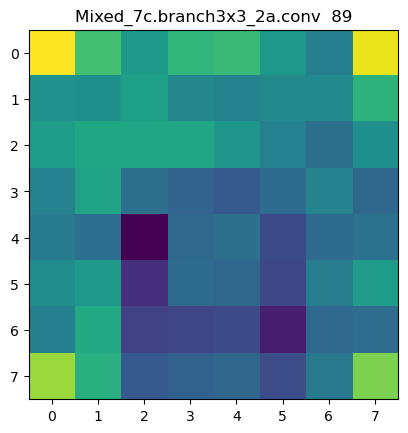

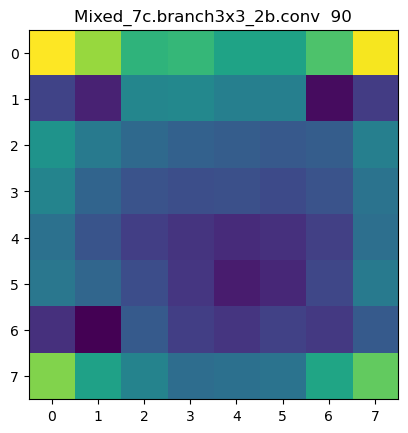

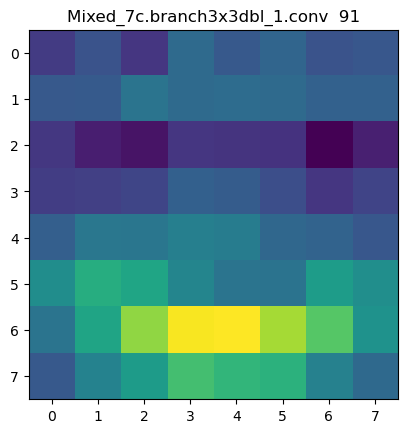

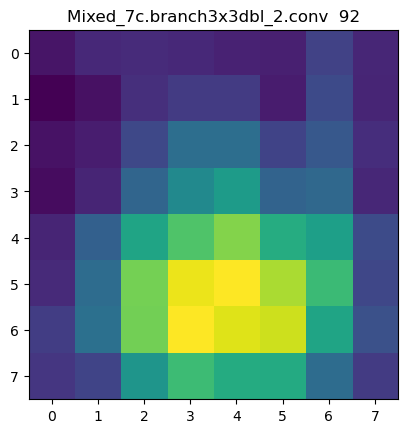

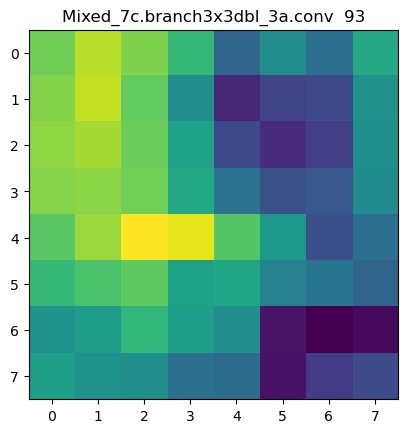

In [73]:
def visualize_features(path):
    """Pre-processes the image located at the passed path, and visualizes the feature maps of each conv layer"""
    # Load and preprocess the cat image
    input_image = Image.open(path)
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    #define two lists to capture the feature maps, and the names of respective layer
    features = []
    names = []
    
    # Define a hook function to capture the outputs
    def hook_fn(module, input, output):
        features.append(output)
    
    
    # Register hooks to the desired layers
    for name, layer in model.named_modules():
        
        if isinstance(layer, torch.nn.Conv2d):
            layer.register_forward_hook(hook_fn)
            names.append(name)
            
    
    # Pass the image through the model
    with torch.no_grad():
        _ = model(input_batch)
    j = 1
    # Visualize the features
    for i, feature in enumerate(features):
    
        feature = feature.detach().numpy()
        fig = plt.figure()
        
        ax = fig.add_subplot()
        
        ax.imshow(feature[0][0])
        ax.set_title('{}  {}'.format(names[i], i))
        plt.show()

visualize_features(path)

It seems that up to layer named "Mixed_6a.branch3x3dbl_3.conv", high level features like edges are recognized. Subsequent layers seem to highlight zones of the picture that correspond to cat-specific features, like ears, eyes, or pattern of the fur. Let's confirm this observation with another picture. Let's try with a lighthouse.

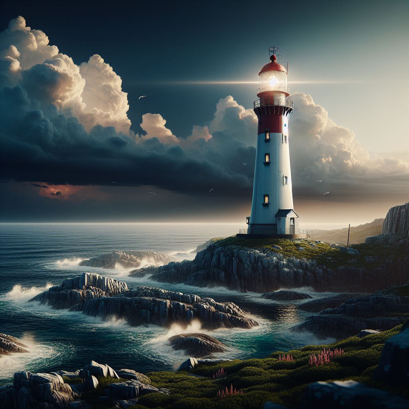

In [79]:
path = 'images/lighthouse.jpeg'
# Load the image
image = Image.open(path)

# Display the image
display(image.resize(( int(image.width * .4), int(image.height * .4))))


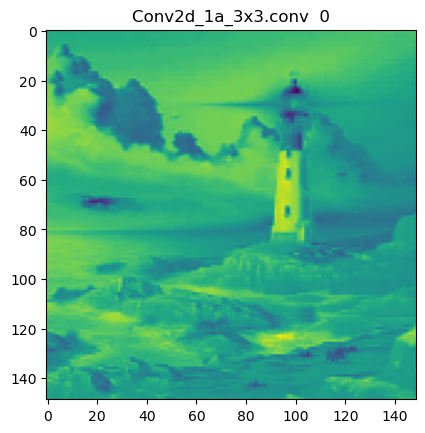

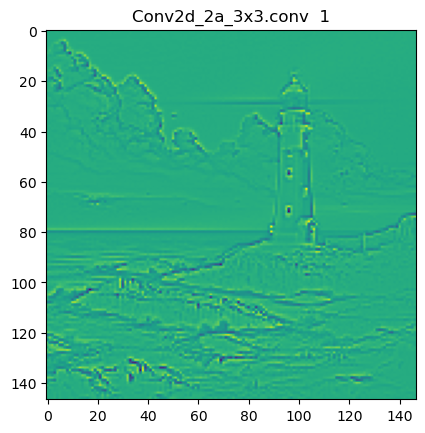

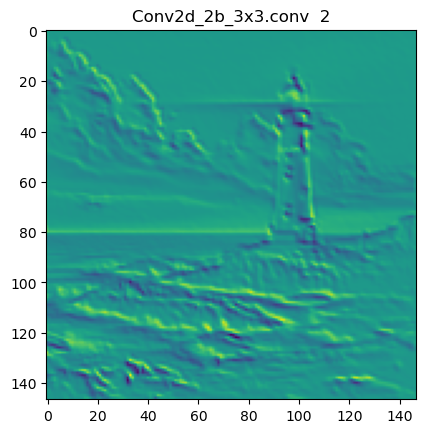

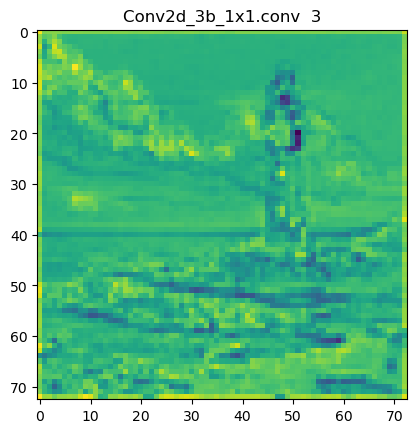

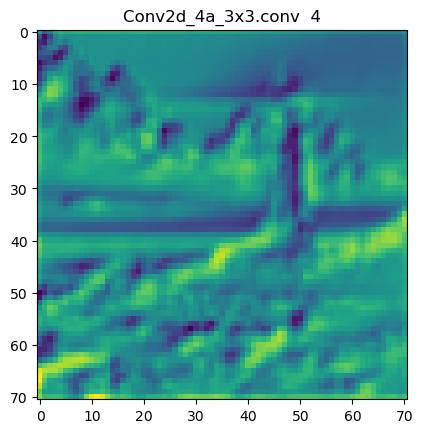

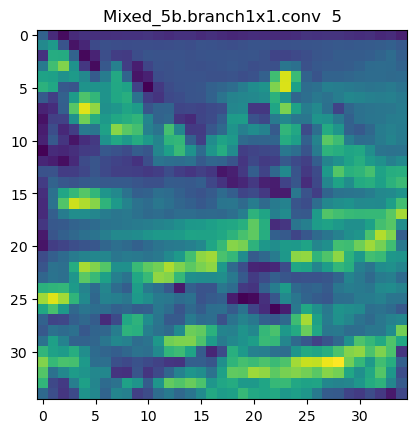

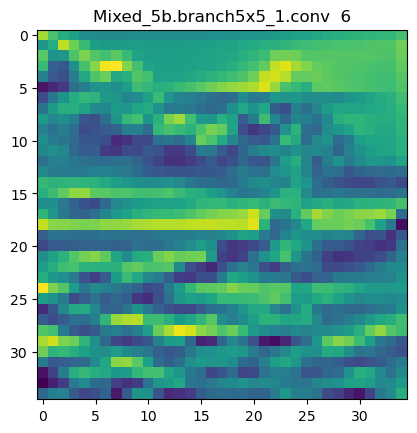

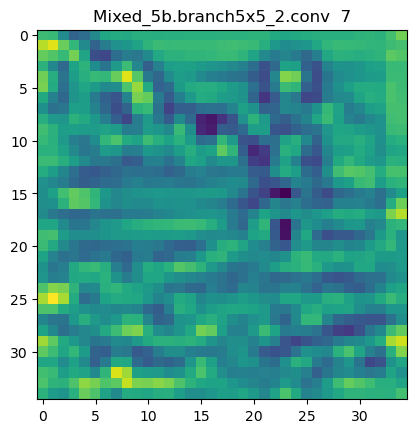

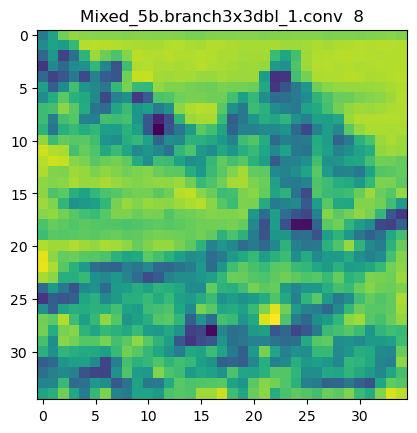

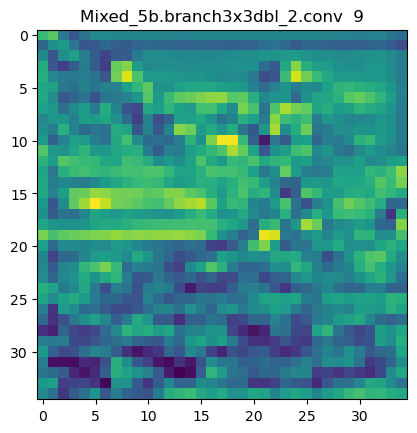

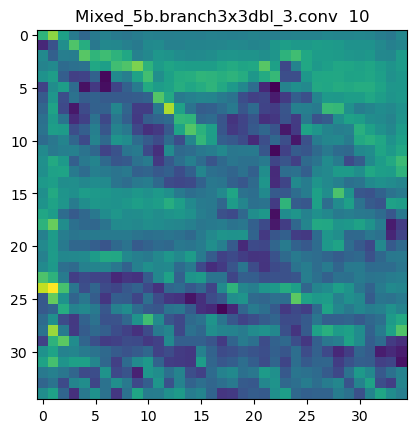

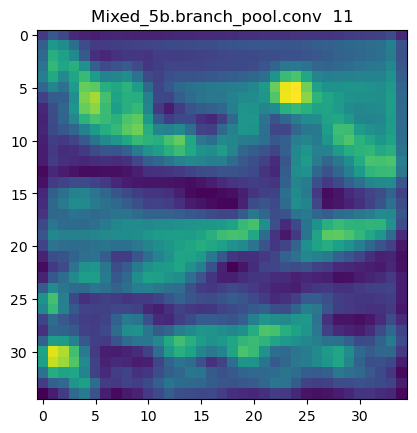

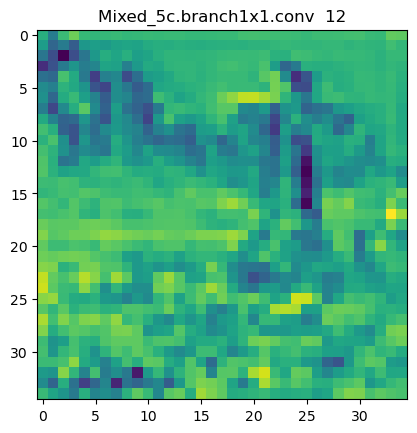

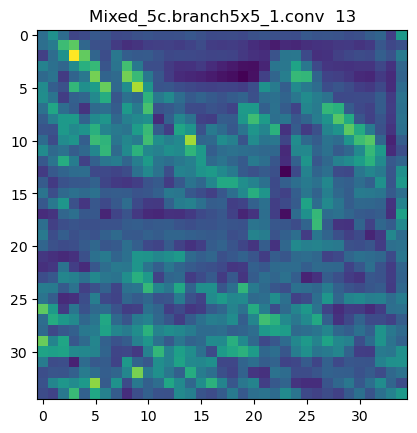

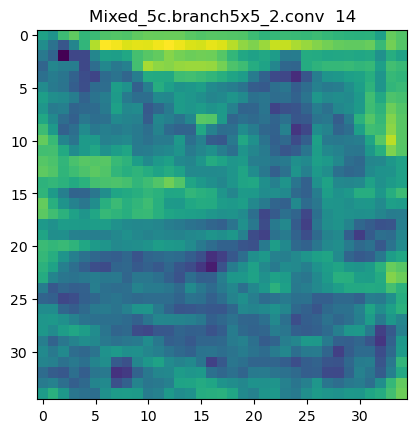

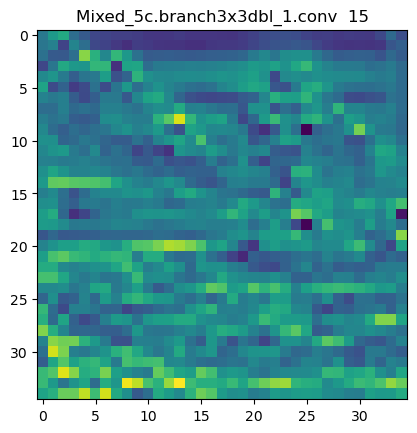

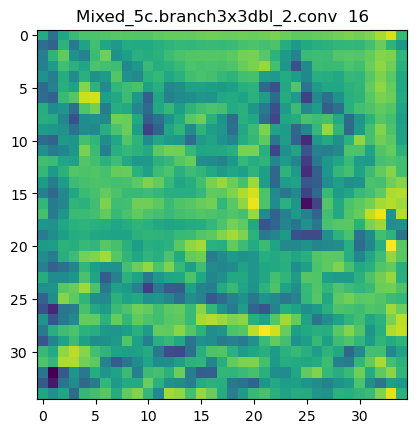

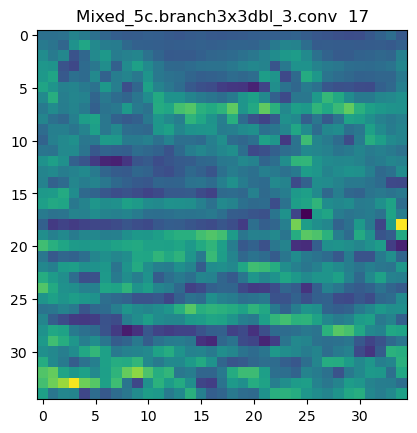

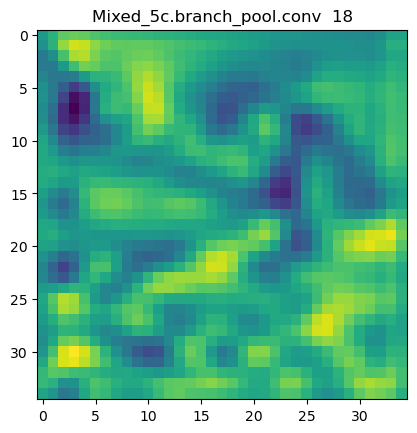

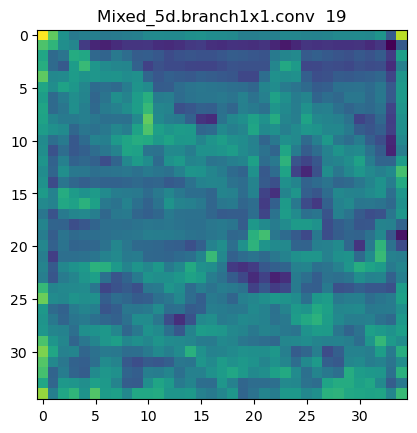

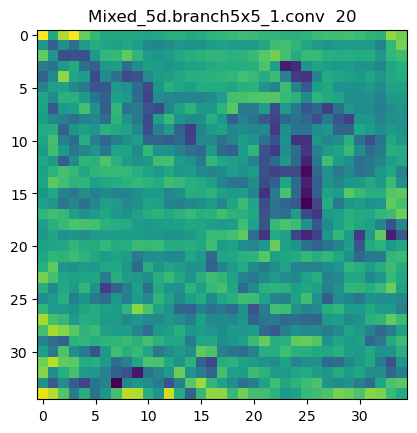

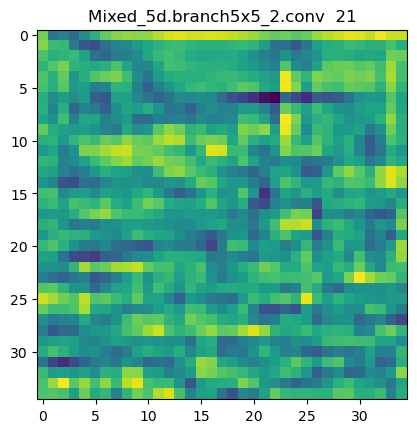

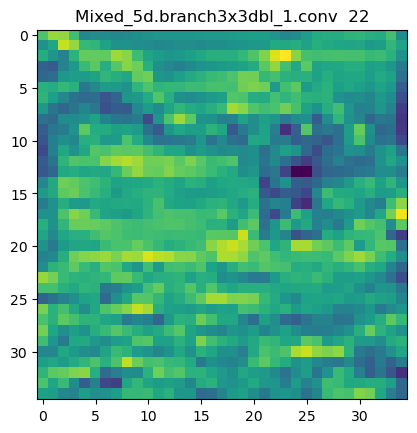

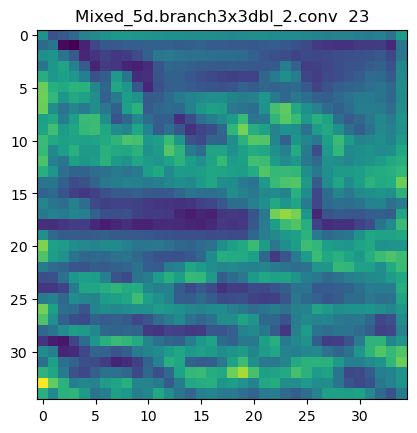

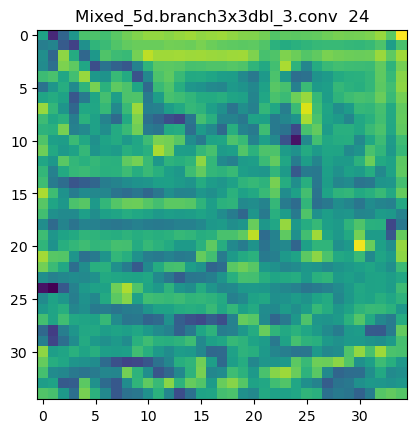

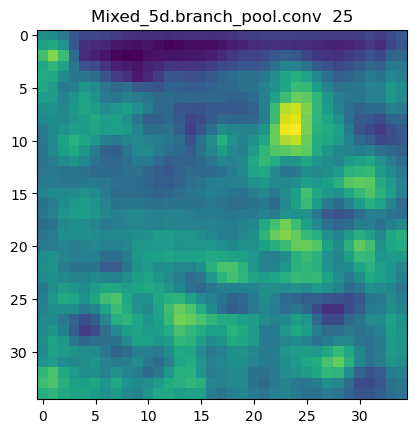

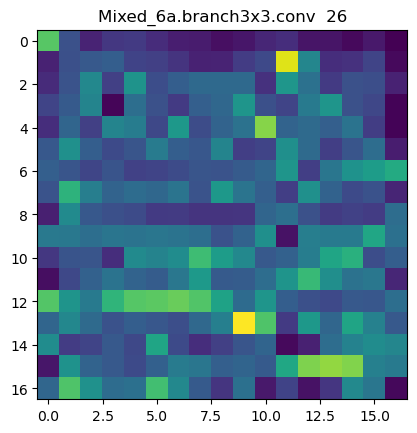

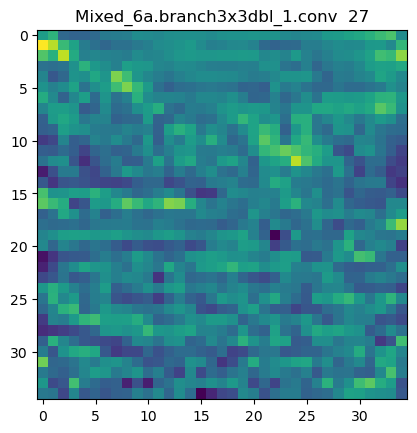

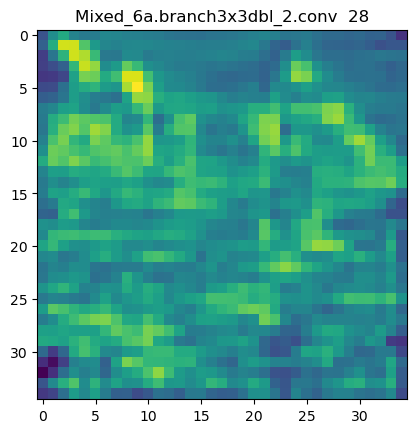

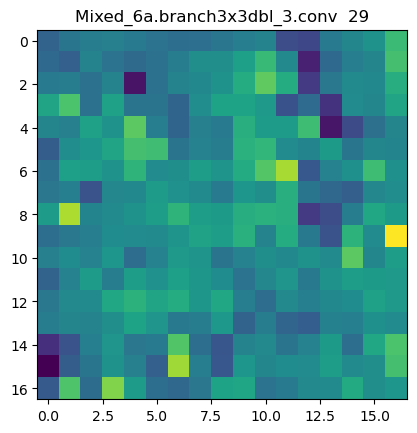

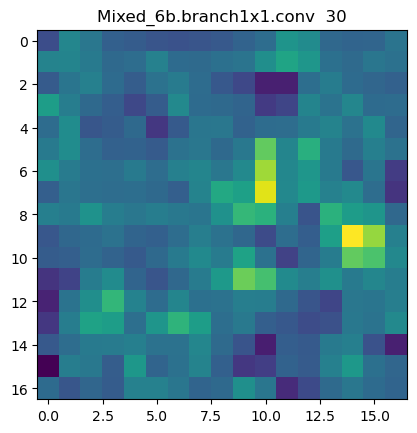

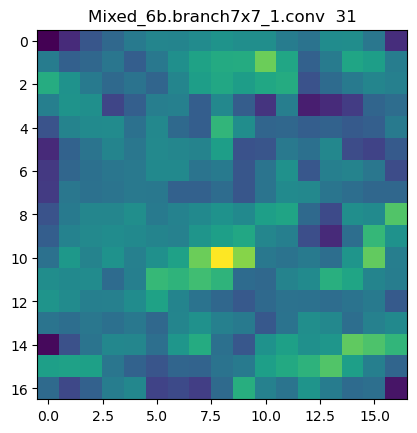

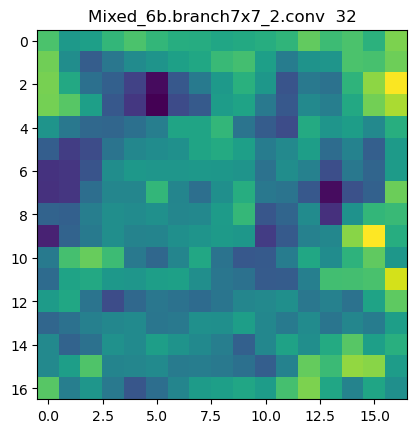

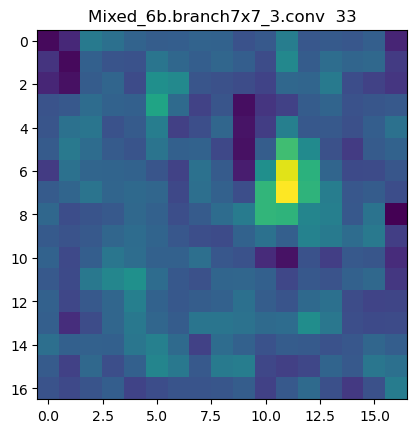

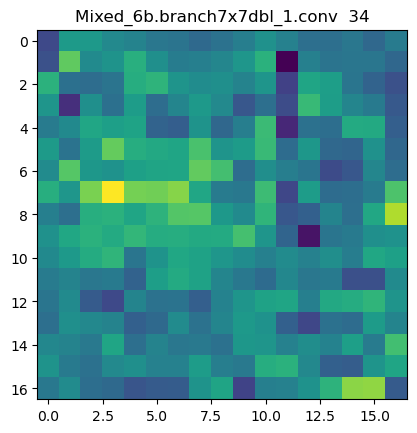

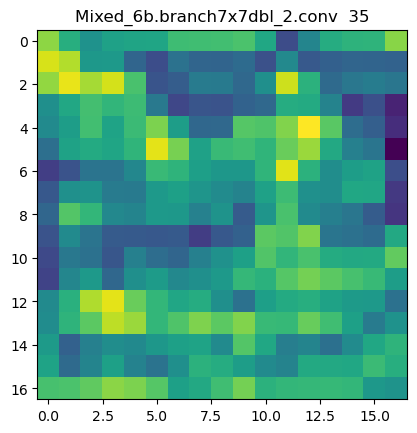

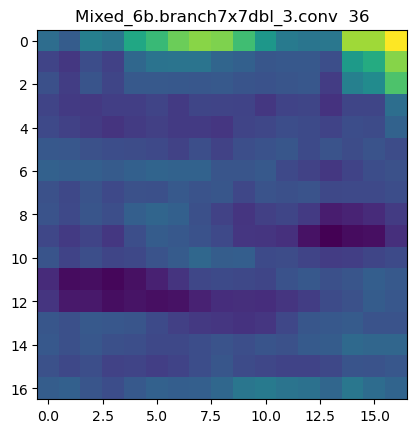

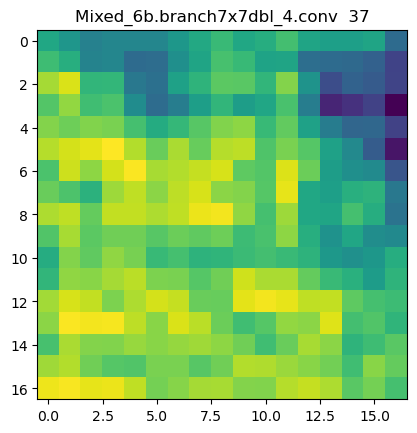

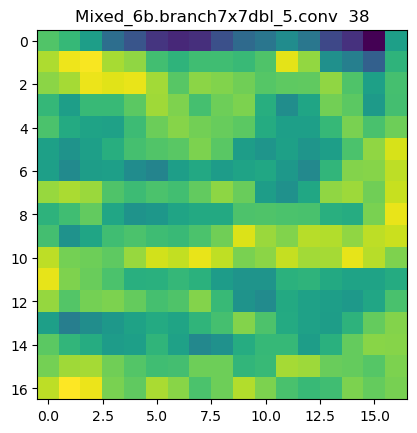

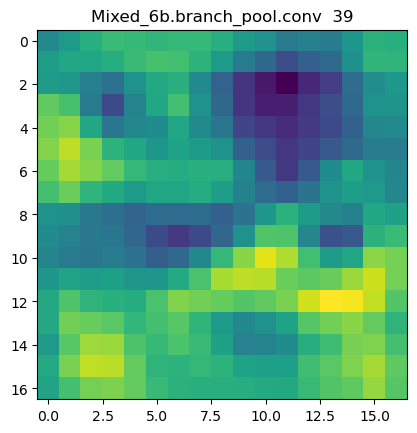

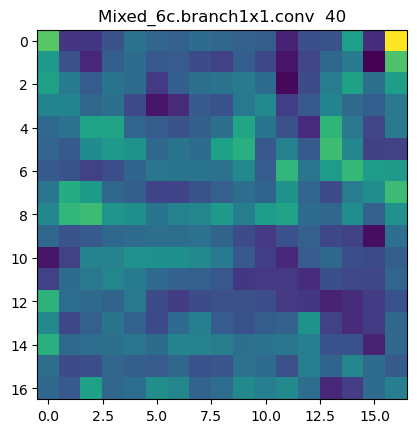

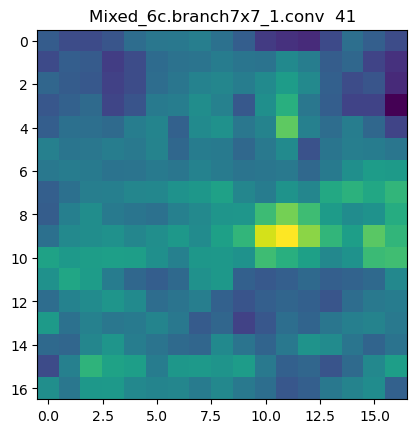

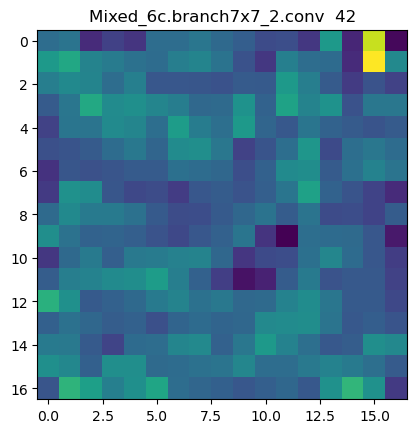

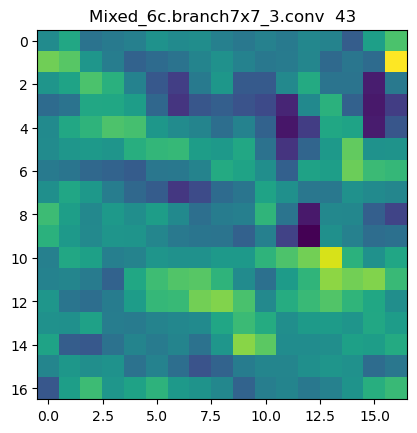

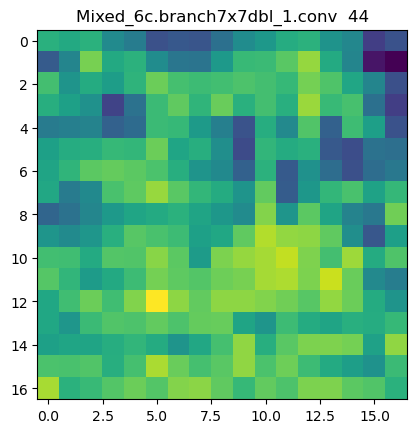

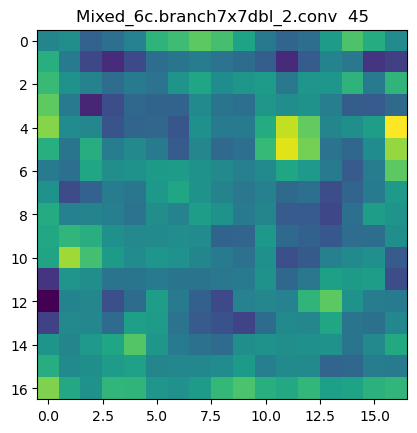

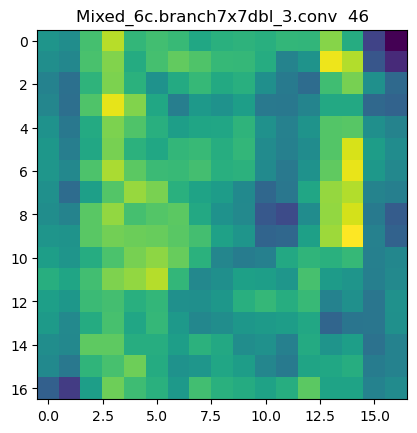

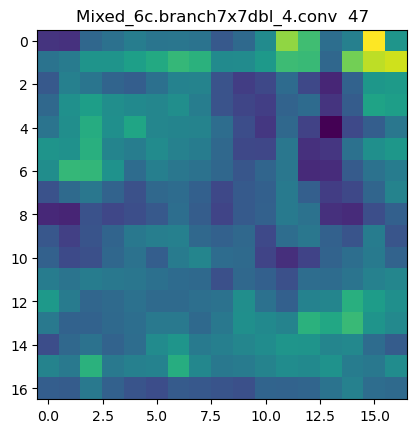

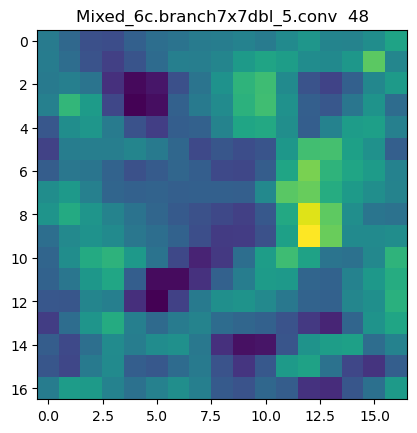

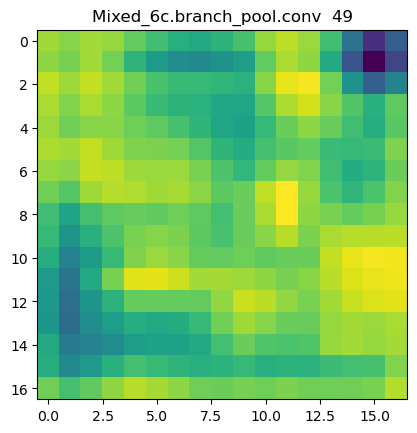

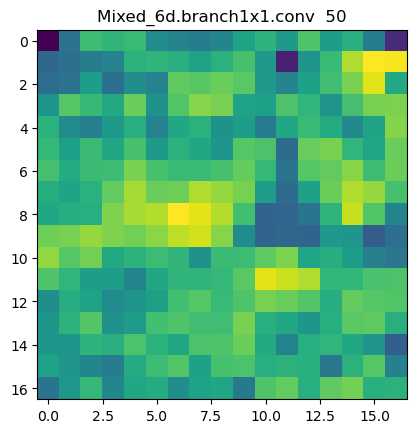

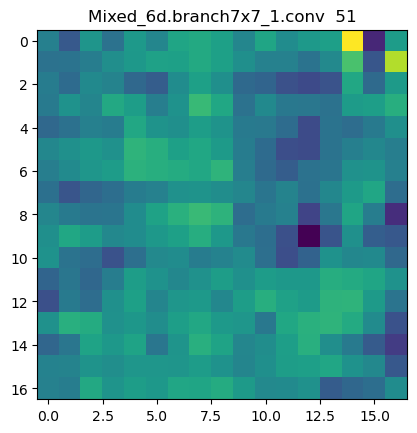

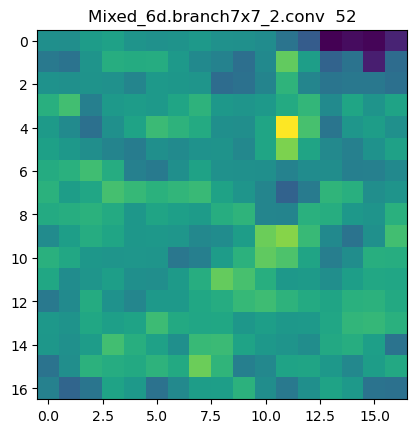

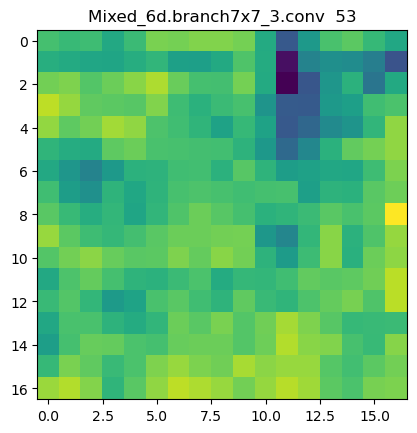

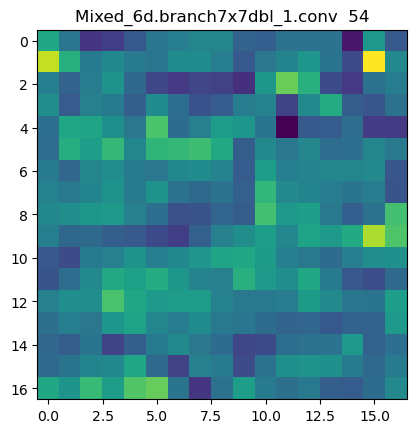

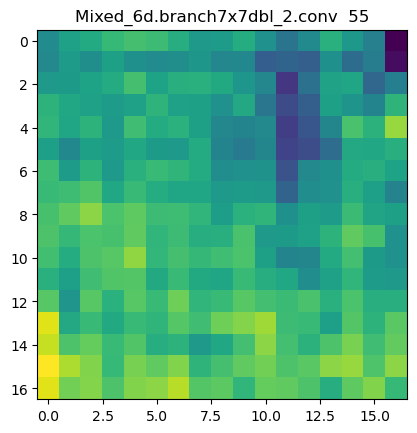

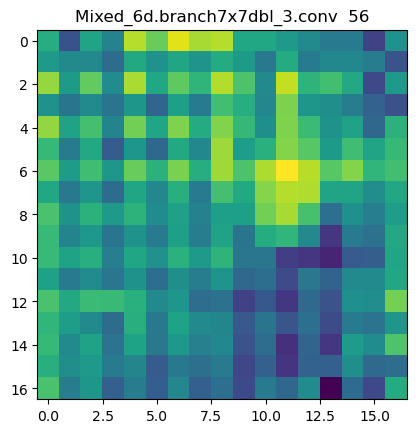

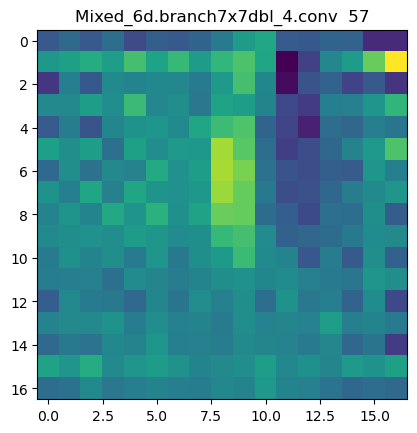

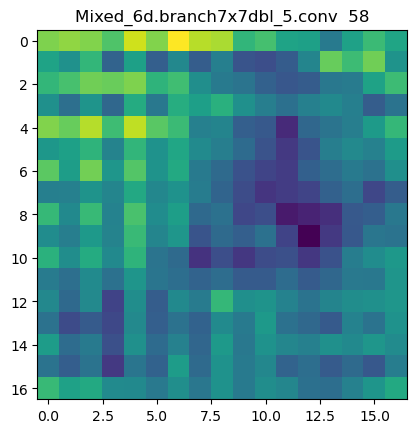

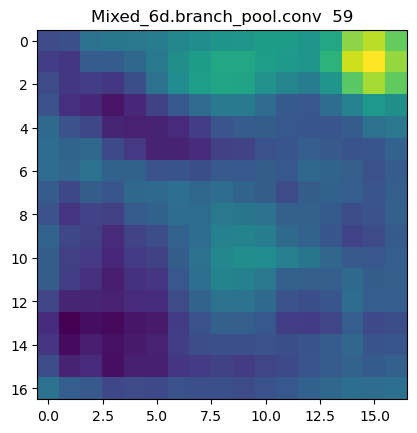

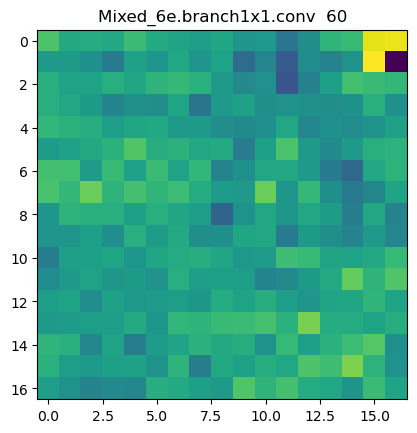

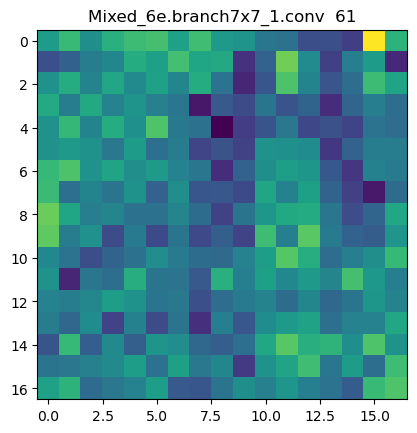

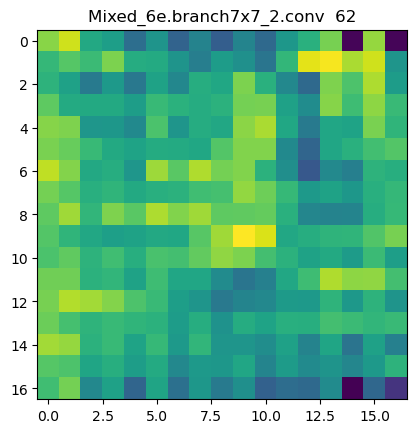

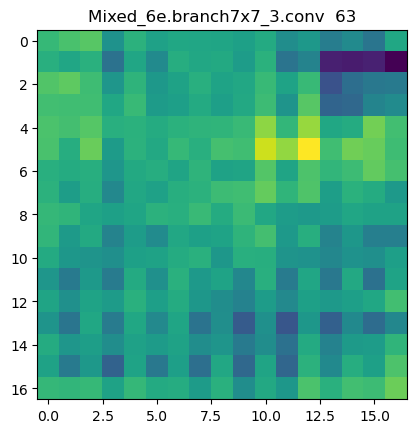

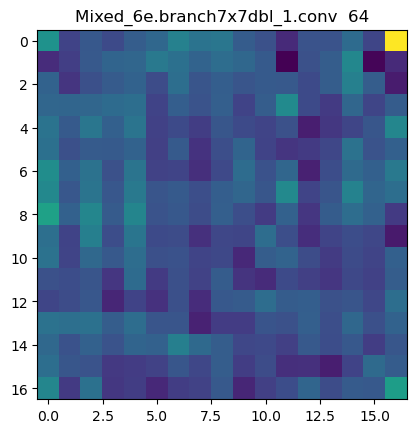

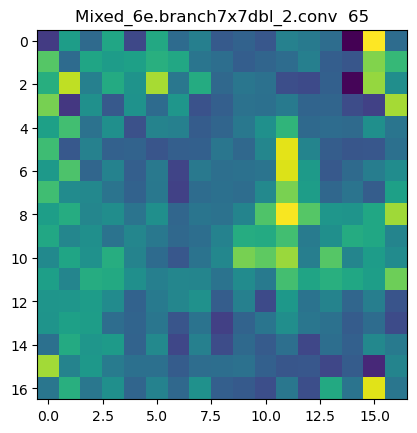

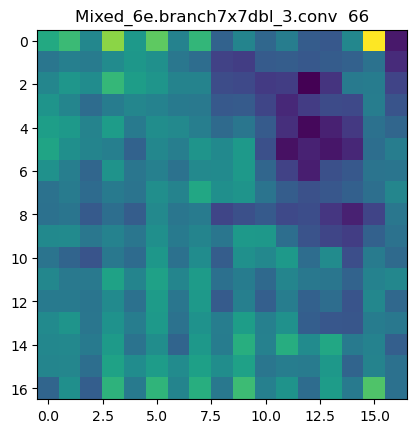

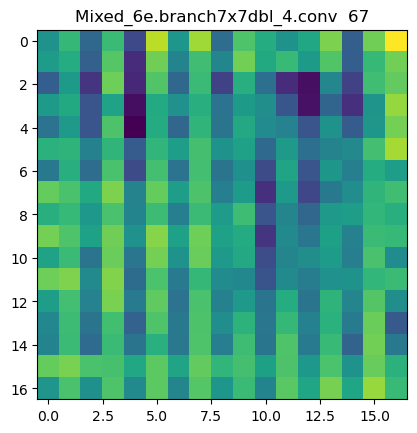

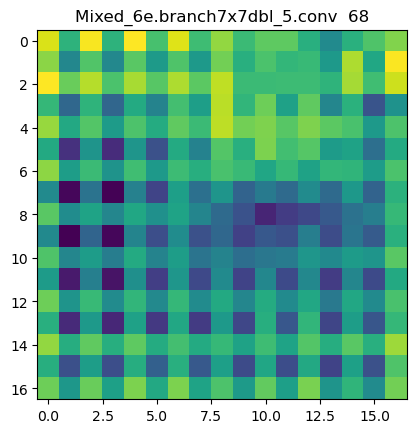

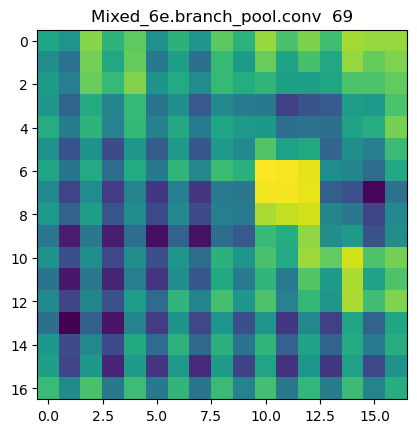

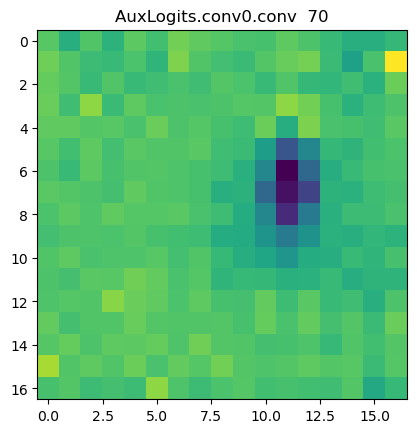

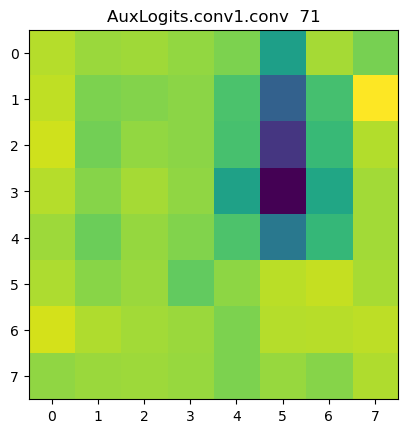

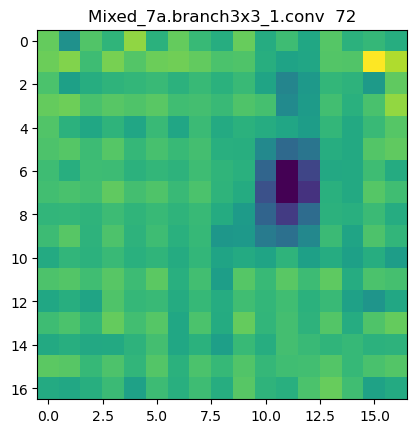

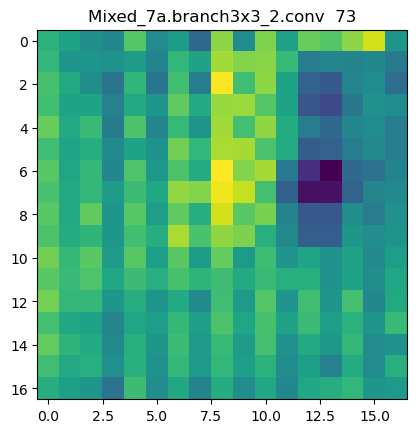

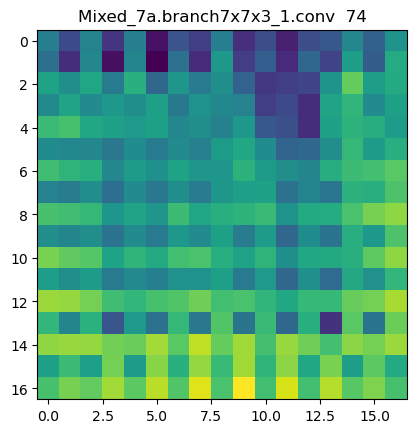

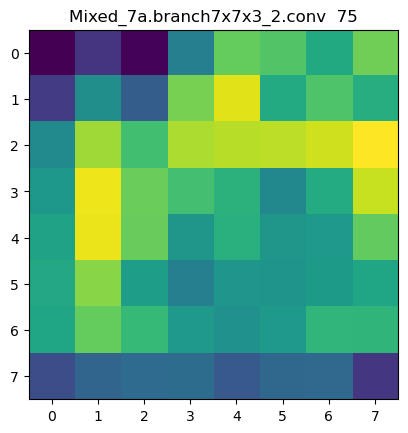

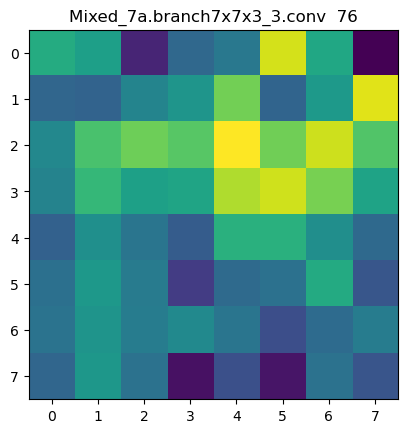

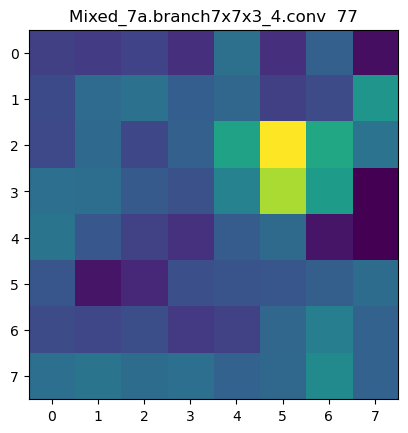

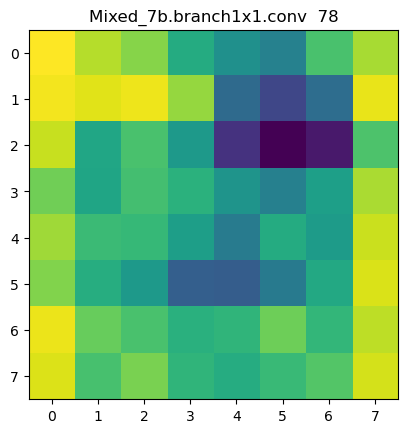

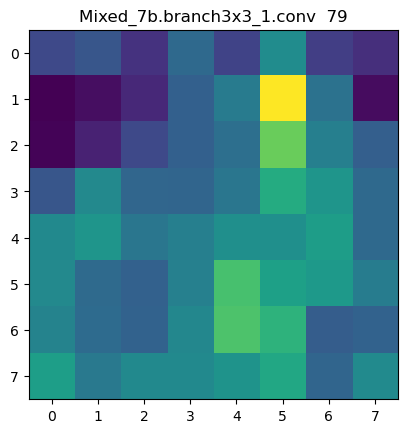

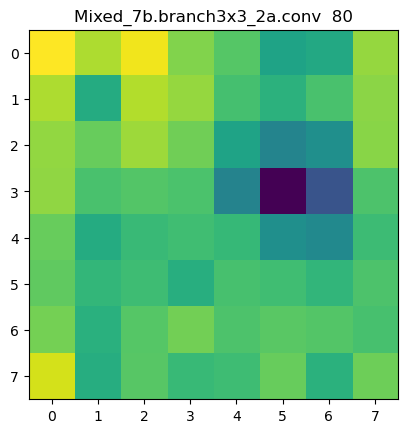

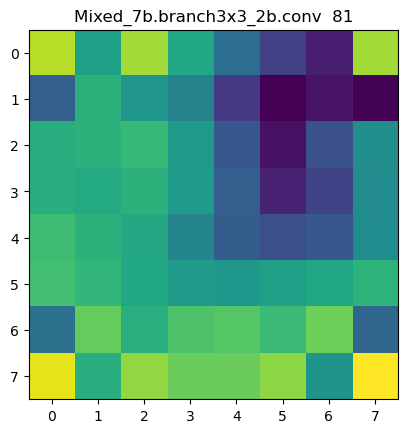

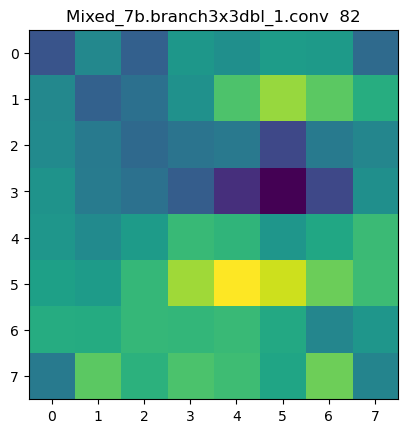

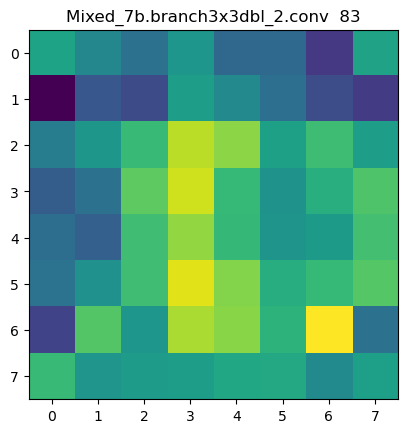

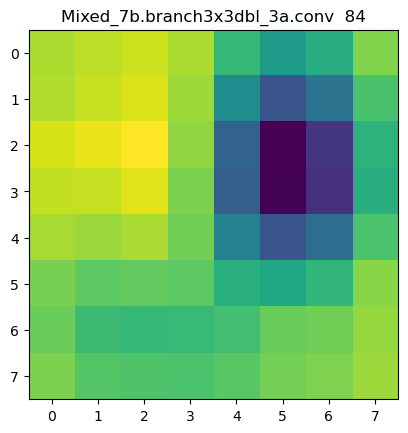

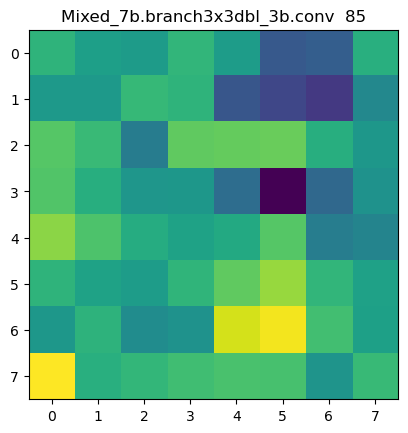

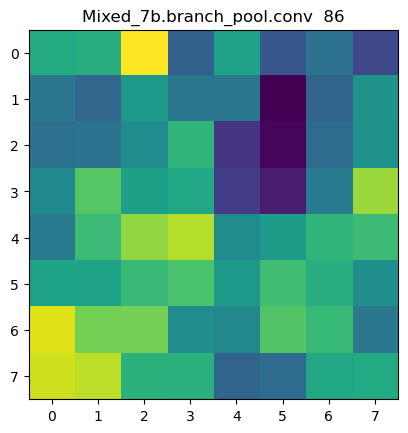

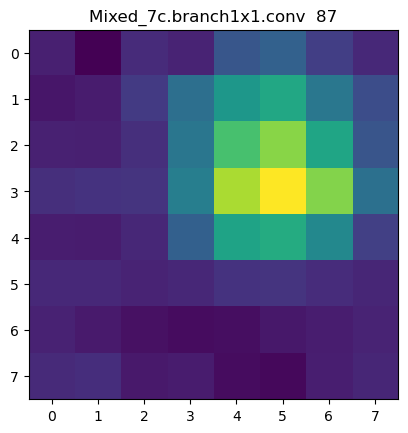

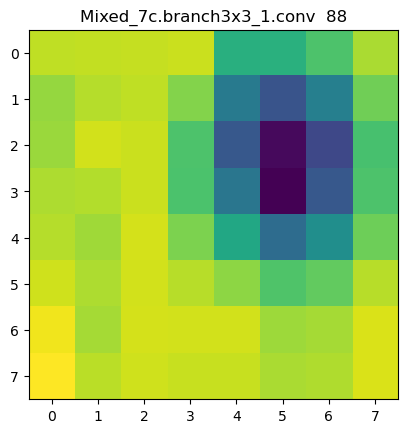

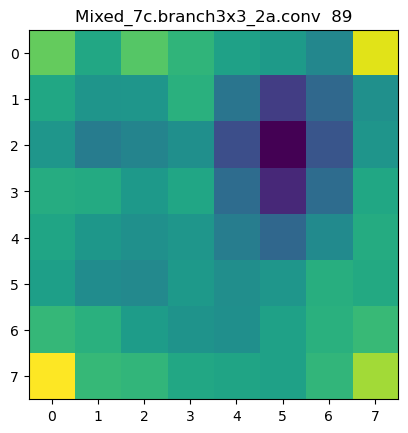

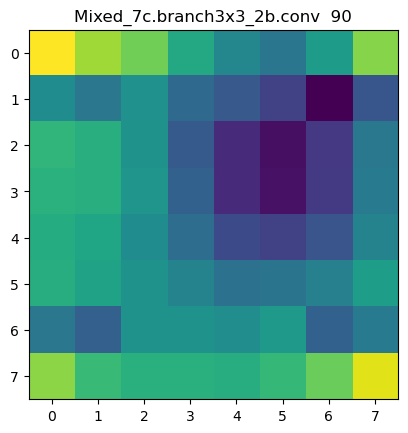

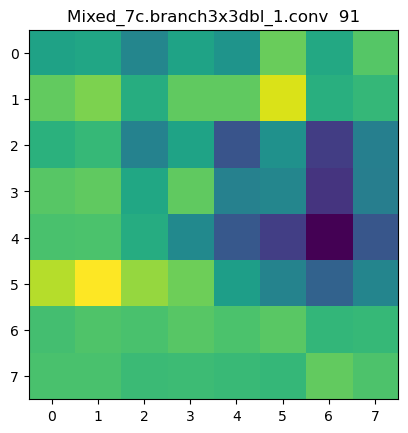

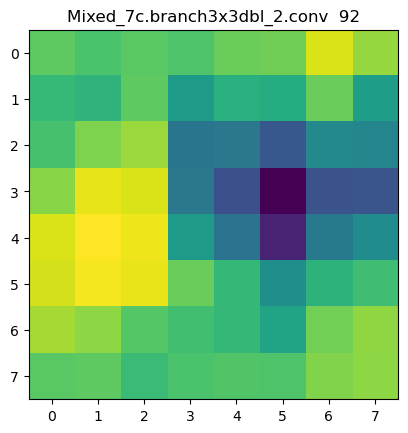

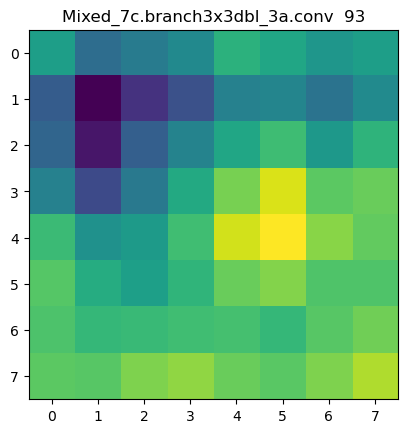

In [80]:
visualize_features(path)

Here again, approximately up to layer named "Mixed_6a.branch3x3dbl_3.conv", mostly edges are recognized. We will try to fine tune the weights of the CNN from this layer on, on images from our dataset.